In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from vizard_utils import functional
from vizard_utils import constant
from vizard_utils import logic
from vizard_utils import PDFIO
from vizard_utils import preprocessor


# MLOps
import dvc.api
import mlflow

plt.style.use('fivethirtyeight')
import mplcyberpunk
plt.style.use('cyberpunk')
%matplotlib inline

<span style="color:gold">See #9 issue.</span>

## General Functions For All Sections

In [2]:
def detect_outliers(df,features):
    from collections import Counter

    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indices
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indices
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

## Loading Data


### Setup DVC experiment and configs

In [3]:
# main path
SRC_DIR = '/mnt/e/dataset/processed/all/'  # path to source encrypted pdf
DST_DIR = 'raw-dataset/all/'  # path to decrypted pdf

# MLFlow configs
# data versioning config
PATH = DST_DIR[:-1] + '.pkl'  # path to source data, e.g. data.pkl file
REPO = '/home/nik/visaland-visa-form-utility'
VERSION = 'v1.0.0'  # use latest using `git tag`

# experiment configs
MLFLOW_EXPERIMENT_NAME = 'exploratory data analysis - jupyter lab'
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
MLFLOW_TAGS = {
    'stage': 'dev'  # dev, beta, production
}
mlflow.set_tags(MLFLOW_TAGS)


### Set global options for the notebook

In [4]:
# pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# matplotlib
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# seaborn
# color_palette = sns.color_palette("husl", 9)
# sns.set_palette(color_palette)

### Import data from DVC storage

In [5]:
# get url data from DVC data storage
data_url = dvc.api.get_url(path=PATH, repo=REPO, rev=VERSION)
# read dataset from remote (local) data storage
data = pd.read_pickle(data_url)

### Getting to know the data

In [6]:
data.head()

,P1.AdultFlag,P1.PD.ServiceIn.ServiceIn,P1.PD.VisaType.VisaType,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.PlaceBirthCity,P1.PD.PlaceBirthCountry,P1.PD.Citizenship.Citizenship,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.CurrCOR.Row2.Other,P1.PD.PCRIndicator,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row2.Status,P1.PD.PrevCOR.Row3.Country,P1.PD.PrevCOR.Row3.Status,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.PD.CWA.Row2.Other,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P2.MS.SecA.TypeOfRelationship,P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue,P2.MS.SecA.Langs.languages.nativeLang.nativeLang,P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate,P2.MS.SecA.Langs.LangTest,P2.natID.q1.natIDIndicator,P2.natID.natIDdocs.CountryofIssue.CountryofIssue,P2.USCard.q1.usCardIndicator,P2.CI.cntct.PhnNums.Phn.CanadaUS,P2.CI.cntct.PhnNums.AltPhn.CanadaUS,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Other.Other,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Occ.Occ,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Occ.Occ,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Occ.Occ,P3.Occ.OccRow3.Country.Country,P3.BGI.Details.MedicalDetails,P3.BGI.otherThanMedic,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P3.PWrapper.criminalRec,P3.PWrapper.Military.Choice,P3.PWrapper.politicViol,P3.PWrapper.witnessIllTreat,P1.PD.CurrCOR.Row2.Period,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.PrevSpouseDOB.DOBYear.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult
0,True,1.0,VisitorVisa,F

In [7]:
# remove duplicates
data.drop_duplicates(inplace=True)

In [8]:
data.isnull().sum()[data.isnull().sum() != 0] #checking for total null values

P1.AdultFlag                                              3
P1.PD.ServiceIn.ServiceIn                                 3
P1.PD.VisaType.VisaType                                   3
P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator     3
P1.PD.Sex.Sex                                             3
                                                         ..
p1.SecC.Chd.[2].ChdDOB.Period                            26
p1.SecC.Chd.[3].ChdDOB.Period                            26
p1.SecC.Chd.[4].ChdDOB.Period                            26
p1.SecC.Chd.[5].ChdDOB.Period                            26
p1.SecC.Chd.[6].ChdDOB.Period                            26
Length: 153, dtype: int64

it seems we have 4 rows with no information (empty forms) but the flag exists. There is nothing we can do except deleting them.

In [9]:
data[data['P1.PD.VisaType.VisaType'].isna()]

,P1.AdultFlag,P1.PD.ServiceIn.ServiceIn,P1.PD.VisaType.VisaType,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.PlaceBirthCity,P1.PD.PlaceBirthCountry,P1.PD.Citizenship.Citizenship,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.CurrCOR.Row2.Other,P1.PD.PCRIndicator,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row2.Status,P1.PD.PrevCOR.Row3.Country,P1.PD.PrevCOR.Row3.Status,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.PD.CWA.Row2.Other,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P2.MS.SecA.TypeOfRelationship,P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue,P2.MS.SecA.Langs.languages.nativeLang.nativeLang,P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate,P2.MS.SecA.Langs.LangTest,P2.natID.q1.natIDIndicator,P2.natID.natIDdocs.CountryofIssue.CountryofIssue,P2.USCard.q1.usCardIndicator,P2.CI.cntct.PhnNums.Phn.CanadaUS,P2.CI.cntct.PhnNums.AltPhn.CanadaUS,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Other.Other,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Occ.Occ,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Occ.Occ,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Occ.Occ,P3.Occ.OccRow3.Country.Country,P3.BGI.Details.MedicalDetails,P3.BGI.otherThanMedic,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P3.PWrapper.criminalRec,P3.PWrapper.Military.Choice,P3.PWrapper.politicViol,P3.PWrapper.witnessIllTreat,P1.PD.CurrCOR.Row2.Period,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.PrevSpouseDOB.DOBYear.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult
10,NaN,NaN,NaN,NaN,NaN,N

In [10]:
data = data.drop(data[data['P1.PD.VisaType.VisaType'].isna()].index)
data.isnull().sum()[data.isnull().sum() != 0]

p1.SecA.Sps.SpsCOB                70
p1.SecA.Mo.MoCOB                   8
p1.SecA.Fa.FaCOB                   8
p1.SecB.Chd.[0].ChdDOB.Period    111
p1.SecB.Chd.[1].ChdDOB.Period    111
p1.SecB.Chd.[2].ChdDOB.Period    111
p1.SecB.Chd.[3].ChdDOB.Period    111
p1.SecC.Chd.[0].ChdDOB.Period     23
p1.SecC.Chd.[1].ChdDOB.Period     23
p1.SecC.Chd.[2].ChdDOB.Period     23
p1.SecC.Chd.[3].ChdDOB.Period     23
p1.SecC.Chd.[4].ChdDOB.Period     23
p1.SecC.Chd.[5].ChdDOB.Period     23
p1.SecC.Chd.[6].ChdDOB.Period     23
dtype: int64

We can see the only two type of data are missing:
1. COB: country of birth
2. Period: age of sibling and kids (probably because the person does not have any kid or sibling to fill)

| Feature | Fill | Desc |
| --- | --- | --- |
| COB | str: same as applicant's COB for ghost spouse | If all SpsCOB are the same, just drop the entire column, so no differentiation between ghost spouse or missed one.  
| Period | int: 0 | prob only ghost cases, otherwise, should be filled statistically 

In [11]:
spouse_fields = [c for c in data.columns.values if 'Sps' in c]
spouse_fields

['p1.SecA.Sps.SpsCOB',
 'p1.SecA.Sps.SpsOcc',
 'p1.SecA.Sps.SpsAccomp',
 'p1.SecA.Sps.SpsDOB.Period']

In [12]:
data[data['p1.SecA.Sps.SpsCOB'].isna()][spouse_fields]

,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Sps.SpsDOB.Period
8,None,OTHER,False,0.0
15,None,OTHER,False,0.0
25,None,OTHER,False,0.0
27,None,HOUSEWIFE,True,10368.0
29,None,HOUSEWIFE,True,10368.0
...,...,...,...,...
288,None,OTHER,False,0.0
290,None,OTHER,False,0.0
291,None,OTHER,False,0.0
294,None,OTHER,False,0.0


In [13]:
print(data[data['p1.SecA.Sps.SpsCOB'].isna()][spouse_fields].__len__())
print(data[(data['p1.SecA.Sps.SpsOcc'] == 'OTHER') & (data['p1.SecA.Sps.SpsCOB'].isna())][spouse_fields].__len__())

70
67


There are 70-67 cases where the person has job title but no COB, which means that only 3 cases are not ghost cases and we can fill their COB using their spouse's COB.
For all other cases (ghosts), we just use the dominant case, IRAN. 

In [14]:
# fill ghost cases' COB with 'IRAN'
data.loc[(data['p1.SecA.Sps.SpsOcc'] == 'OTHER') & (data['p1.SecA.Sps.SpsCOB'].isna()), ['p1.SecA.Sps.SpsCOB']] = 'IRAN'

In [15]:
print(data[data['p1.SecA.Sps.SpsCOB'].isna()][spouse_fields].__len__())
print(data[(data['p1.SecA.Sps.SpsOcc'] == 'OTHER') & (data['p1.SecA.Sps.SpsCOB'].isna())][spouse_fields].__len__())

3
0


In [16]:
# fill non-filled spouse COB cases' with their spouses' COB
data.loc[data['p1.SecA.Sps.SpsCOB'].isna(), ['p1.SecA.Sps.SpsCOB']] = data['P1.PD.PlaceBirthCountry']

In [17]:
print(data[data['p1.SecA.Sps.SpsCOB'].isna()][spouse_fields].__len__())
print(data[(data['p1.SecA.Sps.SpsOcc'] == 'OTHER') & (data['p1.SecA.Sps.SpsCOB'].isna())][spouse_fields].__len__())

0
0


## Analyzing the features

### Ground truth

In [18]:
data.loc[data['VisaResult'] == 1, ['VisaResult']] = 'acc'  # 1 -> accepted
data.loc[data['VisaResult'] == 2, ['VisaResult']] = 'rej'  # 2 -> rejected
data.loc[data['VisaResult'] == 3, ['VisaResult']] = 'w-acc'  # 3 -> allegedly accepted
data.loc[data['VisaResult'] == 4, ['VisaResult']] = 'w-rej'  # 4 -> allegedly rejected
data.loc[data['VisaResult'] == 5, ['VisaResult']] = 'no idea'  # 5 -> no idea
output_hue_order = ['acc', 'rej', 'w-rej', 'w-acc', 'no idea']


/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


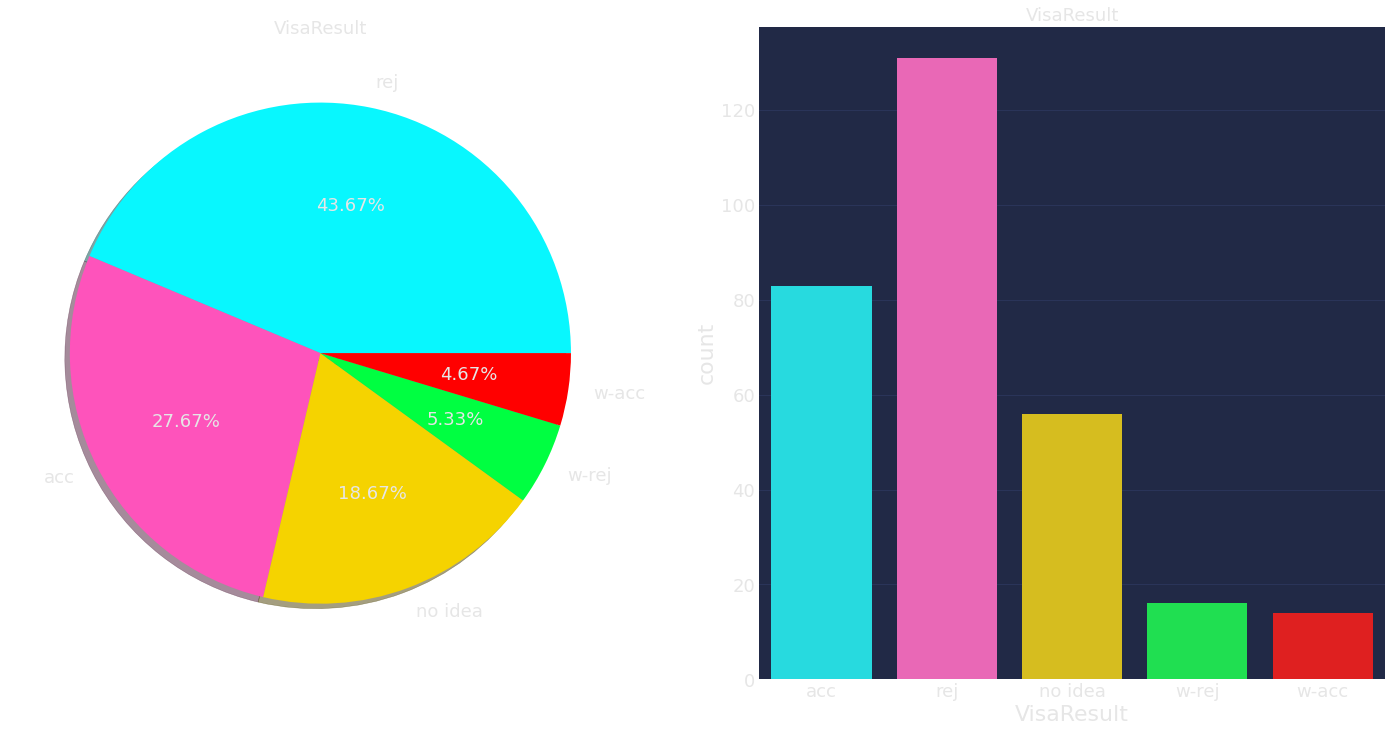

In [19]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data['VisaResult'].value_counts().plot.pie(
    autopct='%1.2f%%', ax=ax[0], shadow=True)
ax[0].set_title('VisaResult')
ax[0].set_ylabel('')
sns.countplot('VisaResult', data=data, ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('VisaResult')
plt.show()

We don't have the labels for %18 of our data, but we have weak labels for around %10. In this way, we can revive 80% of labels by doing weak supervised learning. Check [Snorkel](https://www.snorkel.org/get-started/) for more information. 

### P1.AdultFlag -> categorical

In [20]:
data.groupby(['P1.AdultFlag','VisaResult'])['VisaResult'].count()

P1.AdultFlag  VisaResult
False         acc             1
              rej             1
True          acc            82
              no idea        56
              rej           130
              w-acc          14
              w-rej          16
Name: VisaResult, dtype: int64

In [21]:
data[data['P1.AdultFlag'] == False]

,P1.AdultFlag,P1.PD.ServiceIn.ServiceIn,P1.PD.VisaType.VisaType,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.PlaceBirthCity,P1.PD.PlaceBirthCountry,P1.PD.Citizenship.Citizenship,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.CurrCOR.Row2.Other,P1.PD.PCRIndicator,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row2.Status,P1.PD.PrevCOR.Row3.Country,P1.PD.PrevCOR.Row3.Status,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.PD.CWA.Row2.Other,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P2.MS.SecA.TypeOfRelationship,P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue,P2.MS.SecA.Langs.languages.nativeLang.nativeLang,P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate,P2.MS.SecA.Langs.LangTest,P2.natID.q1.natIDIndicator,P2.natID.natIDdocs.CountryofIssue.CountryofIssue,P2.USCard.q1.usCardIndicator,P2.CI.cntct.PhnNums.Phn.CanadaUS,P2.CI.cntct.PhnNums.AltPhn.CanadaUS,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Other.Other,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Occ.Occ,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Occ.Occ,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Occ.Occ,P3.Occ.OccRow3.Country.Country,P3.BGI.Details.MedicalDetails,P3.BGI.otherThanMedic,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P3.PWrapper.criminalRec,P3.PWrapper.Military.Choice,P3.PWrapper.politicViol,P3.PWrapper.witnessIllTreat,P1.PD.CurrCOR.Row2.Period,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.PrevSpouseDOB.DOBYear.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult
15,False,1.0,VisitorVisa

Ok, useless kids, dropping all of them, and hence, the entire `P1.AdultFlag` flag

In [22]:
data.drop('P1.AdultFlag', axis=1, inplace=True)

### P1.PD.ServiceIn.ServiceIn -> categorical

In [23]:
data.groupby(['P1.PD.ServiceIn.ServiceIn','VisaResult'])['VisaResult'].count()

P1.PD.ServiceIn.ServiceIn  VisaResult
1.0                        acc            83
                           no idea        56
                           rej           131
                           w-acc          14
                           w-rej          16
Name: VisaResult, dtype: int64

In [24]:
# drop useless
data.drop('P1.PD.ServiceIn.ServiceIn', axis=1, inplace=True)

### P1.PD.ServiceIn.ServiceIn -> categorical

In [25]:
data.groupby(['P1.PD.VisaType.VisaType','VisaResult'])['VisaResult'].count()

P1.PD.VisaType.VisaType  VisaResult
VisitorVisa              acc            83
                         no idea        56
                         rej           131
                         w-acc          14
                         w-rej          16
Name: VisaResult, dtype: int64

In [26]:
# drop useless
data.drop('P1.PD.VisaType.VisaType', axis=1, inplace=True)

### P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator -> categorical

In [27]:
output_name = 'VisaResult'
feature_name = 'P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator  VisaResult
False                                                  acc            76
                                                       no idea        54
                                                       rej           118
                                                       w-acc          12
                                                       w-rej          16
True                                                   acc             7
                                                       no idea         2
                                                       rej            13
                                                       w-acc           2
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


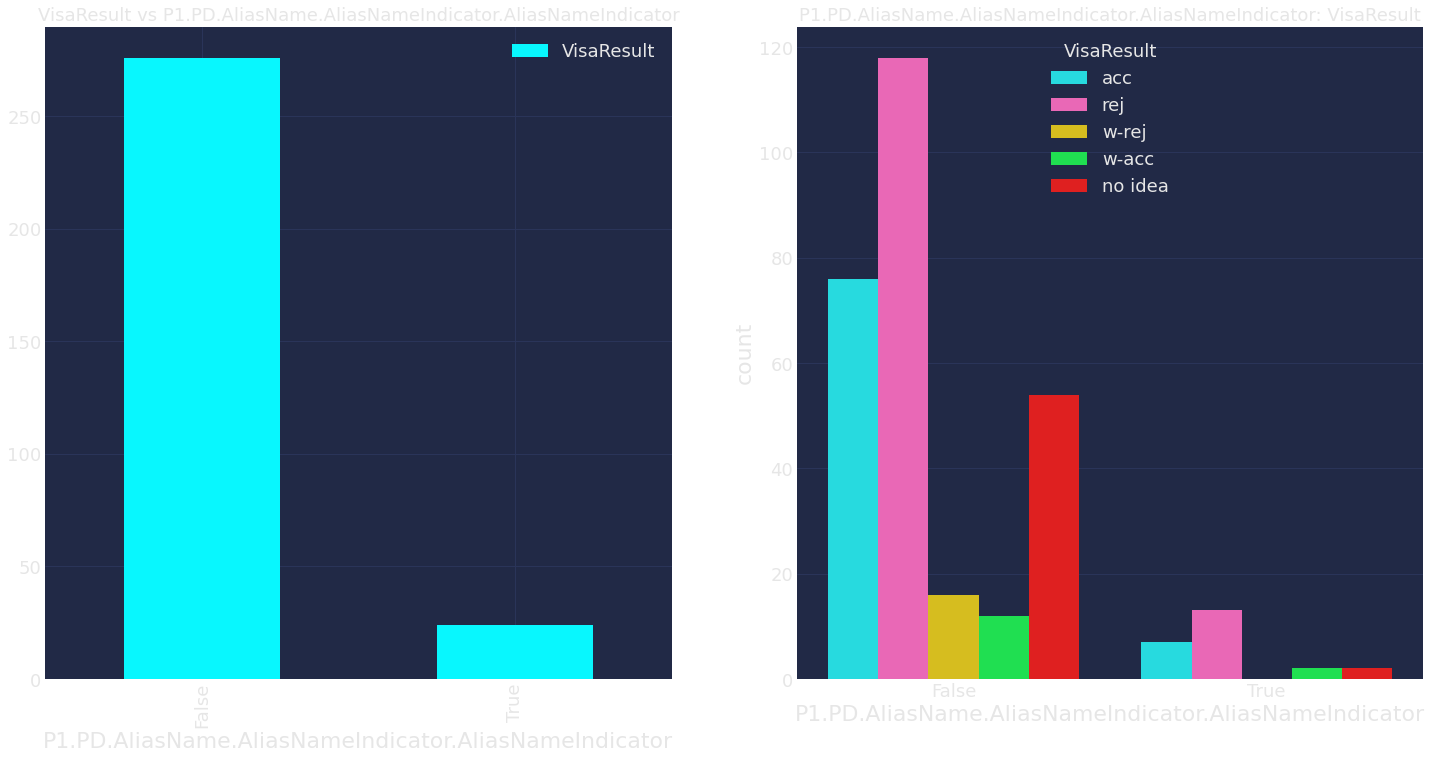

In [28]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data, ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

TODO: They seem proportional, for now, we skip it, but if after modeling, we didn't find any improvement by including this feature, we must remove it.

### P1.PD.Sex.Sex -> categorical

In [29]:
output_name = 'VisaResult'
feature_name = 'P1.PD.Sex.Sex'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.Sex.Sex  VisaResult
Female         acc           47
               no idea       28
               rej           60
               w-acc          6
               w-rej          9
Male           acc           36
               no idea       28
               rej           71
               w-acc          8
               w-rej          7
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


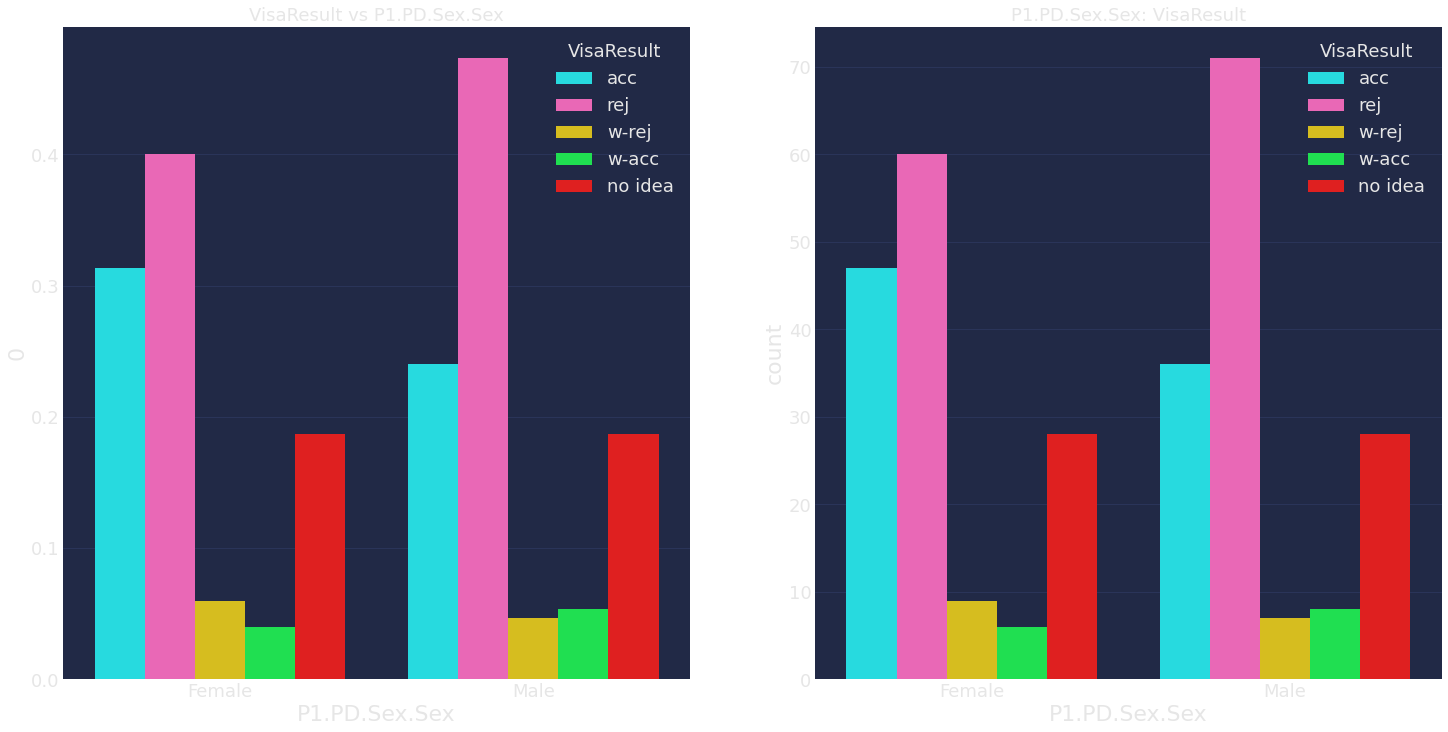

In [30]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
z = data[[feature_name, output_name]].groupby(
    [feature_name]).value_counts(normalize=True).reset_index()
sns.barplot(x=feature_name, y=0, hue=output_name, data=z, ax=ax[0], hue_order=output_hue_order)
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data, ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

**It seems that women are getting more visas than man, even though the number of applicants in term of gender are almost equal.**

### P1.PD.PlaceBirthCity -> categorical

In [31]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PlaceBirthCity'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PlaceBirthCity  VisaResult
ABADAN                acc           2
                      no idea       1
AHVAZ                 acc           1
                      rej           2
                      w-acc         2
                                   ..
Tehran                rej           4
VARAMIN               no idea       1
ZANJAN                acc           2
                      no idea       2
esfahan               no idea       1
Name: VisaResult, Length: 118, dtype: int64

In [32]:
pd.crosstab(data[feature_name], data[output_name],
            margins=True).style.background_gradient(cmap='summer_r')

VisaResult,acc,no idea,rej,w-acc,w-rej,All
P1.PD.PlaceBirthCity,,,,,,
ABADAN,2,1,0,0,0,3
AHVAZ,1,0,2,2,0,5
AMOL,0,1,0,0,0,1
ANDIMESHK,1,0,1,0,0,2
ARAK,0,0,2,0,0,2
ARDEBIL,4,0,2,0,0,6
Abadan,0,0,1,0,0,1
BABOL,1,1,1,2,0,5
BAFGH,0,0,1,0,0,1


The data fro other cities except Tehran, Karaj and Shiraz is too small to matter. At the end of the day, the value of land is summarized into assets, so no point in this, hence deleted.

In [33]:
# drop useless
data.drop('P1.PD.PlaceBirthCity', axis=1, inplace=True)

### P1.PD.PlaceBirthCountry -> categorical

In [34]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PlaceBirthCountry'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PlaceBirthCountry  VisaResult
059                      rej             1
226                      no idea         1
IRAN                     acc            83
                         no idea        55
                         rej           130
                         w-acc          14
                         w-rej          16
Name: VisaResult, dtype: int64

Well, all are from damned Iran, so let's drop it.

In [35]:
# drop useless
data.drop('P1.PD.PlaceBirthCountry', axis=1, inplace=True)

### P1.PD.Citizenship.Citizenship -> categorical

In [36]:
output_name = 'VisaResult'
feature_name = 'P1.PD.Citizenship.Citizenship'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.Citizenship.Citizenship  VisaResult
IRAN                           acc            83
                               no idea        56
                               rej           129
                               w-acc          14
                               w-rej          16
TURKEY                         rej             2
Name: VisaResult, dtype: int64

In [37]:
# drop useless
data.drop('P1.PD.Citizenship.Citizenship', axis=1, inplace=True)

### P1.PD.CurrCOR.Row2.Country -> categorical

In [38]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CurrCOR.Row2.Country'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.CurrCOR.Row2.Country  VisaResult
280                         acc             1
511                         acc             1
IRAN                        acc            81
                            no idea        56
                            rej           131
                            w-acc          14
                            w-rej          16
Name: VisaResult, dtype: int64

511 is Canada and someone who has residency of Canada absolutely needs to be excluded as an anomaly.

In [39]:
data.drop(data[data[feature_name] == '511'].index, inplace=True)

It is hard to say that how having different country of residence than IRAN effects the output variable. So know more about it, especially if it is **anomaly** or not, we currently skip it and after having a clean data, we use visualization, statistical or ML methods to figure this out. [See this for more information](https://www.analyticsvidhya.com/blog/2021/04/dealing-with-anomalies-in-the-data/)

We can also make this into categorical, [`IRAN`, `OTHER`] and simplify things, but if it's anomaly, I prefer fixing it.

TODO: last priority but mandatory

### P1.PD.CurrCOR.Row2.Status -> categorical

In [40]:
data[data['P1.PD.CurrCOR.Row2.Country'] != 'IRAN']['P1.PD.CurrCOR.Row2.Status']

140    2.0
Name: P1.PD.CurrCOR.Row2.Status, dtype: float64

Similar as [P1.PD.CurrCOR.Row2.Country](#P1.PD.CurrCOR.Row2.Country)

### P1.PD.CurrCOR.Row2.Other -> categorical

In [41]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CurrCOR.Row2.Other'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.CurrCOR.Row2.Other  VisaResult
False                     acc            82
                          no idea        56
                          rej           131
                          w-acc          14
                          w-rej          16
Name: VisaResult, dtype: int64

In [42]:
# drop useless
data.drop('P1.PD.CurrCOR.Row2.Other', axis=1, inplace=True)

### P1.PD.PCRIndicator -> categorical

In [43]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PCRIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PCRIndicator  VisaResult
False               acc            76
                    no idea        56
                    rej           128
                    w-acc          14
                    w-rej          12
True                acc             6
                    rej             3
                    w-rej           4
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


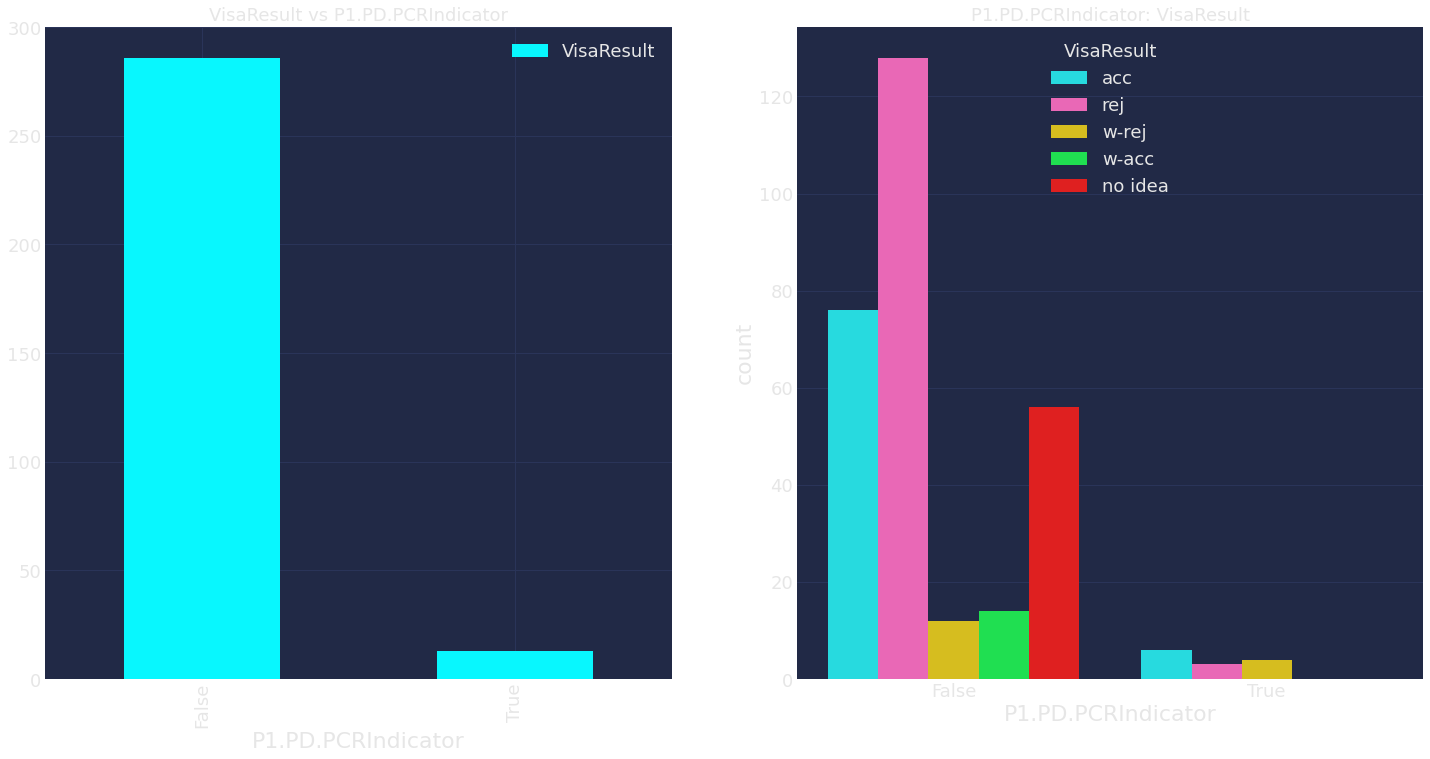

In [44]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data, ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

It is hard to say, but having previous country of residence has higher acceptance rate than none ones. Well, this is maybe the case, because they showed that they have resided in third-party countries and went back to their home country.

### P1.PD.PrevCOR.Row[i].\* -> categorical

In [45]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PrevCOR.Row2.Country'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PrevCOR.Row2.Country  VisaResult
016                         w-rej           2
028                         acc             1
                            rej             2
034                         acc             1
052                         acc             2
202                         w-rej           1
224                         w-rej           1
226                         rej             1
280                         acc             1
OTHER                       acc            76
                            no idea        56
                            rej           128
                            w-acc          14
                            w-rej          12
TURKEY                      acc             1
Name: VisaResult, dtype: int64

Ok, we have good amount of examples that cannot be ignored or labeled as anomaly.

The main issue here is that the countries are so diverse that cannot be considered. To fix this, we consider label feature `P1.PD.PCRIndicator` which is a binary variable indicating if the candidate has had previous country of residence or not. The below cell confirms this, so we drop this column and second row of the same info, i.e. `P1.PD.PrevCOR.Row2.Country`, `P1.PD.PrevCOR.Row2.Status`, `P1.PD.PrevCOR.Row3.Country`, `P1.PD.PrevCOR.Row3.Status`.

All these columns can be integrated into another column, aggregating all of these into sum of non-`OTHER` status for PrevCOR, simply put, the count of previous countries of residence. In this case, `0` means no PCR, so we can get rid of `P1.PD.PCRIndicator` too.

In [46]:
data[data['P1.PD.PCRIndicator'] == True].groupby([feature_name, output_name])[output_name].count()

P1.PD.PrevCOR.Row2.Country  VisaResult
016                         w-rej         2
028                         acc           1
                            rej           2
034                         acc           1
052                         acc           2
202                         w-rej         1
224                         w-rej         1
226                         rej           1
280                         acc           1
TURKEY                      acc           1
Name: VisaResult, dtype: int64

In [47]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PrevCOR.Row2.Country'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PrevCOR.Row2.Country  VisaResult
016                         w-rej           2
028                         acc             1
                            rej             2
034                         acc             1
052                         acc             2
202                         w-rej           1
224                         w-rej           1
226                         rej             1
280                         acc             1
OTHER                       acc            76
                            no idea        56
                            rej           128
                            w-acc          14
                            w-rej          12
TURKEY                      acc             1
Name: VisaResult, dtype: int64

In [48]:
output_name = 'VisaResult'
data.groupby(['P1.PD.PrevCOR.Row2.Status', 'P1.PD.PrevCOR.Row3.Status']).size()

P1.PD.PrevCOR.Row2.Status  P1.PD.PrevCOR.Row3.Status
2.0                        6.0                            1
3.0                        3.0                            1
                           6.0                            1
4.0                        6.0                            3
5.0                        6.0                            3
6.0                        6.0                          290
dtype: int64

In [49]:
from functools import reduce
import re
r = re.compile('P1.PD.PrevCOR.Row..Period')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_names = list(data.columns.values[mask])


def previous_residency_country_count(series: pd.Series):
    # 6 means no previous country of residency
    return reduce(lambda x, y: 2 - np.sum(np.isin([x, y], [0])), series)


# replace rows of previous country of residency to count of them
data['P1.PD.PrevCOR.Row.Count'] = data[feature_names].agg([previous_residency_country_count], axis=1)
data = data.rename(
    columns={previous_residency_country_count.__name__: 'P1.PD.PrevCOR.Row.Count'})

# delete redundant columns tnx to newly created 'P1.PD.PrevCOR.Row.Count'
data.drop(['P1.PD.PrevCOR.Row2.Status', 'P1.PD.PrevCOR.Row3.Status', 'P1.PD.PCRIndicator'], axis=1, inplace=True)

In [50]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PrevCOR.Row2.Period', 'P1.PD.PrevCOR.Row3.Period', 'P1.PD.PrevCOR.Row.Count'
data.groupby([*feature_name, output_name])[output_name].count()

P1.PD.PrevCOR.Row2.Period  P1.PD.PrevCOR.Row3.Period  P1.PD.PrevCOR.Row.Count  VisaResult
0.0                        0.0                        0                        acc            76
                                                                               no idea        56
                                                                               rej           128
                                                                               w-acc          14
                                                                               w-rej          12
140.0                      0.0                        1                        w-rej           1
163.0                      0.0                        1                        rej             1
183.0                      0.0                        1                        acc             1
208.0                      0.0                        1                        acc             1
303.0                      0.0       

In [51]:
data.head()

,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row3.Country,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.PD.CWA.Row2.Other,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P2.MS.SecA.TypeOfRelationship,P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue,P2.MS.SecA.Langs.languages.nativeLang.nativeLang,P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate,P2.MS.SecA.Langs.LangTest,P2.natID.q1.natIDIndicator,P2.natID.natIDdocs.CountryofIssue.CountryofIssue,P2.USCard.q1.usCardIndicator,P2.CI.cntct.PhnNums.Phn.CanadaUS,P2.CI.cntct.PhnNums.AltPhn.CanadaUS,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Other.Other,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Occ.Occ,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Occ.Occ,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Occ.Occ,P3.Occ.OccRow3.Country.Country,P3.BGI.Details.MedicalDetails,P3.BGI.otherThanMedic,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P3.PWrapper.criminalRec,P3.PWrapper.Military.Choice,P3.PWrapper.politicViol,P3.PWrapper.witnessIllTreat,P1.PD.CurrCOR.Row2.Period,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.PrevSpouseDOB.DOBYear.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult,P1.PD.PrevCOR.Row.Count
0,False,Female,IRAN,1.0,OTHER,OTHER,True,OTHER,6.0,False,01,False,OTHER,IRAN,IRAN,Neither,False,True,IRAN,False,False,False,8.0,False,10000.0,SON,OTHER,False,IRAN,PERSIAN/PICTURE CARPET WEAVER,IRAN,DRIVING INSTRUCTOR,IRAN,COSMETOLOGY 

#### P1.PD.PrevCOR.Row[i].Country -> categorical -> continuous

In [52]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PrevCOR.Row2.Country'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PrevCOR.Row2.Country  VisaResult
016                         w-rej           2
028                         acc             1
                            rej             2
034                         acc             1
052                         acc             2
202                         w-rej           1
224                         w-rej           1
226                         rej             1
280                         acc             1
OTHER                       acc            76
                            no idea        56
                            rej           128
                            w-acc          14
                            w-rej          12
TURKEY                      acc             1
Name: VisaResult, dtype: int64

In [53]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value


def code_search_dict(string: str, dic: dict, if_nan: str):
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        print('"{}" is not numeric ==> SKIPPED'.format(string))
        return string


data[feature_name] = data[feature_name].apply(func=code_search_dict, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', ))


"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numer

In [54]:
tmp_df = pd.read_pickle('../raw-dataset/API_NY.GDP.PCAP.CD_DS2_en_xml_v2_4004943.pkl')
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [55]:
data[feature_name].unique()

array([1.42985636, 1.75289541, 1.32752412, 1.14233002, 2.33984284,
       2.09999266, 1.        , 1.97140976, 1.16178083, 1.30392442])

In [56]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PrevCOR.Row3.Country'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.PrevCOR.Row3.Country  VisaResult
280                         acc             1
OTHER                       acc            81
                            no idea        56
                            rej           131
                            w-acc          14
                            w-rej          16
Name: VisaResult, dtype: int64

In [57]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value


def code_search_dict(string: str, dic: dict, if_nan: str):
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        print('"{}" is not numeric ==> SKIPPED'.format(string))
        return string


data[feature_name] = data[feature_name].apply(func=code_search_dict, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', ))


"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numeric ==> SKIPPED
"OTHER" is not numer

In [58]:
tmp_df = pd.read_pickle('../raw-dataset/API_NY.GDP.PCAP.CD_DS2_en_xml_v2_4004943.pkl')
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [59]:
data[feature_name].unique()

array([1.42985636, 2.33984284])

### P1.PD.SameAsCORIndicator -> categorical

In [60]:
output_name = 'VisaResult'
feature_name = 'P1.PD.SameAsCORIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.SameAsCORIndicator  VisaResult
False                     acc            75
                          no idea        56
                          rej           126
                          w-acc          14
                          w-rej          13
True                      acc             7
                          rej             5
                          w-rej           3
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


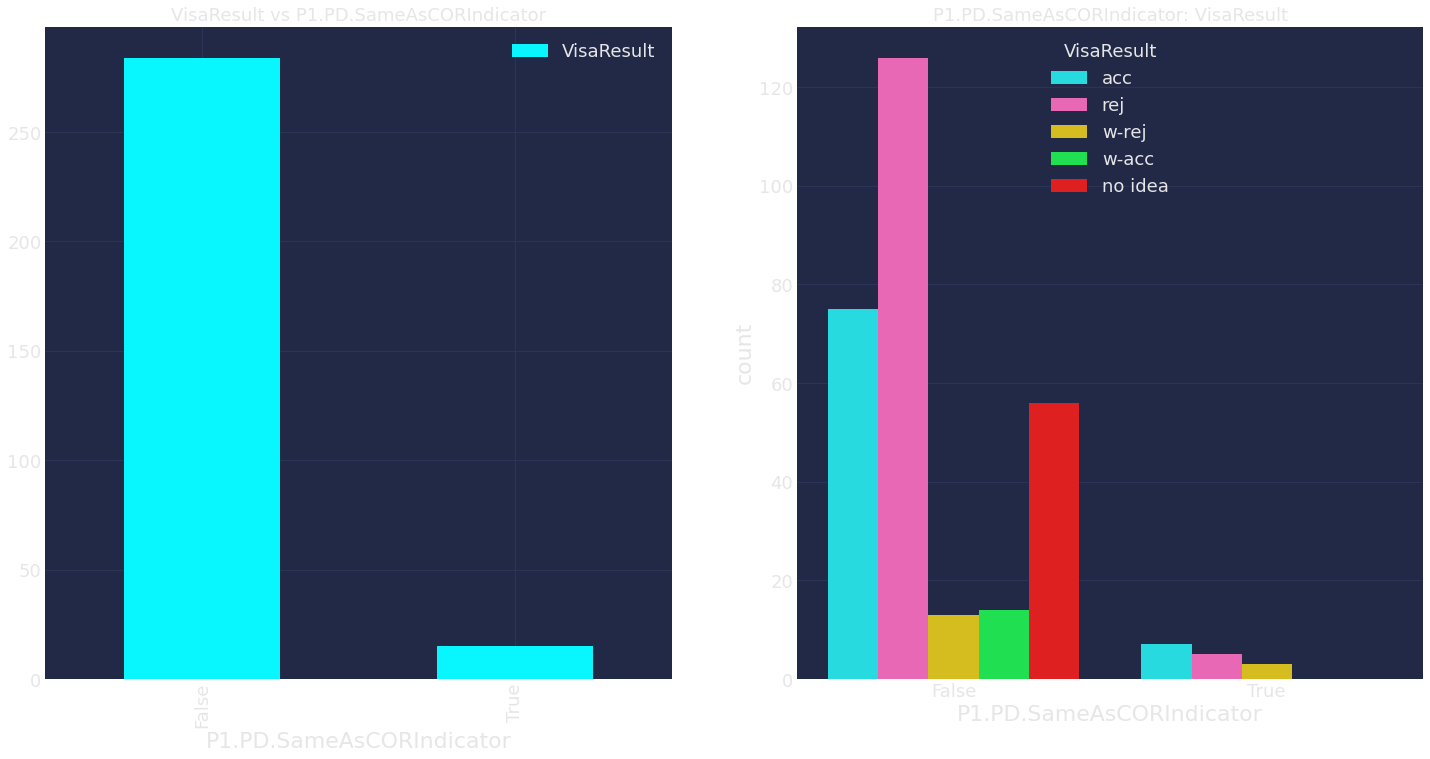

In [61]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


It seems that having residency of other countries improves the chance of getting the visa. Seems like that the person had a choice to be the citizen of any country (by being refugee of course) but legally has chosen another country than the visiting country (here Canada). I.e. the person has no intention to go back to Iran, but no intention to stay in Canada too, a third-party country is taking care of it!

### P1.PD.CWA.Row2.Country -> categorical

In [62]:
output_name = 'VisaResult'
feature_name = ['P1.PD.CWA.Row2.Country', 'P1.PD.PrevCOR.Row.Count']
data.groupby([*feature_name, output_name])[output_name].count()

P1.PD.CWA.Row2.Country  P1.PD.PrevCOR.Row.Count  VisaResult
022                     0                        rej             2
049                     0                        w-acc           1
052                     0                        acc             2
                                                 rej             3
                        1                        acc             1
059                     0                        rej             1
224                     0                        rej             3
242                     0                        no idea         1
263                     0                        rej             1
280                     0                        rej             4
IRAN                    0                        acc             1
                                                 rej             2
                                                 w-rej           2
OTHER                   0                        acc             6
  

In [63]:
# convert numbers to countries and transform them into categories that are more frequent

number_to_country = {
    '049': 'Armenia',
    '052': 'Georgia',
    '280': 'UAE',
    'IRAN': 'TURKEY',  # CWA cannot be Iran, prob Turkey
    'OTHER': 'TURKEY',  # CWA cannot be OTHER, pro Turkey
    'TURKEY': 'TURKEY',
}

def fix_cwa(string: str, dic):
    if string in dic.keys():
        string = string.replace(string, dic[string])
    else:
        string = 'OTHER'
    return string

feature_name = 'P1.PD.CWA.Row2.Country'
data[feature_name] = data[feature_name].apply(
    func=fix_cwa, args=(number_to_country, ))


In [64]:
data['P1.PD.CWA.Row2.Country'].unique()

array(['TURKEY', 'OTHER', 'Georgia', 'UAE', 'Armenia'], dtype=object)

In [65]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Country'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.CWA.Row2.Country  VisaResult
Armenia                 w-acc           1
Georgia                 acc             3
                        rej             3
OTHER                   no idea         1
                        rej             7
TURKEY                  acc            79
                        no idea        55
                        rej           117
                        w-acc          13
                        w-rej          16
UAE                     rej             4
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


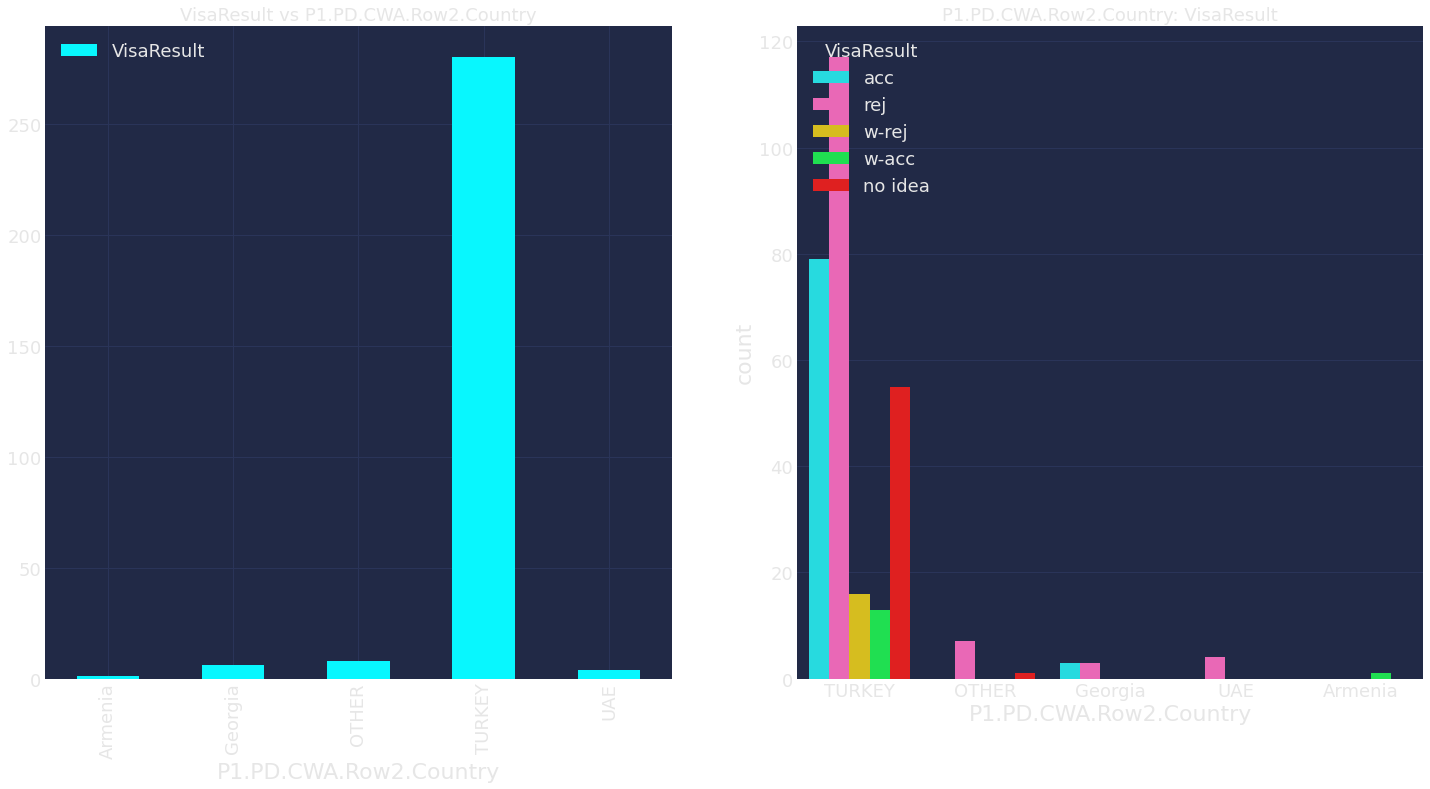

In [66]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

Here, we just are considering countries that usually someone can apply from, which for Iranians, it's Armenia, Georgia, United Arab Emirates, and Turkey.

Note that, we had CWA cases where the person applied from France, or Iraq. Separately categorizing these might be harder, but we can tell that the person whose CWA is france, already has residency status or travel history that making the case stronger, so other variables dominate affect of this.

*Remark:* My goal for including this feature is that to see if there is bias toward specific countries. I.e. in some Reddit (which is legit) post, people mentioned that UAE cases for non UAE cases usually have higher rate of rejection. 


- [ ] TODO: lets find any dataset/news of tourism visa stats w.r.t. countries.

### P1.PD.CWA.Row2.Status -> categorical

In [67]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Status'
data.groupby([feature_name, output_name])[output_name].count()

P1.PD.CWA.Row2.Status  VisaResult
1.0                    acc            1
                       no idea        1
                       rej            4
                       w-acc          2
3.0                    acc           63
                       no idea       20
                       rej           60
                       w-acc          6
                       w-rej          8
6.0                    acc           18
                       no idea       35
                       rej           67
                       w-acc          6
                       w-rej          8
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


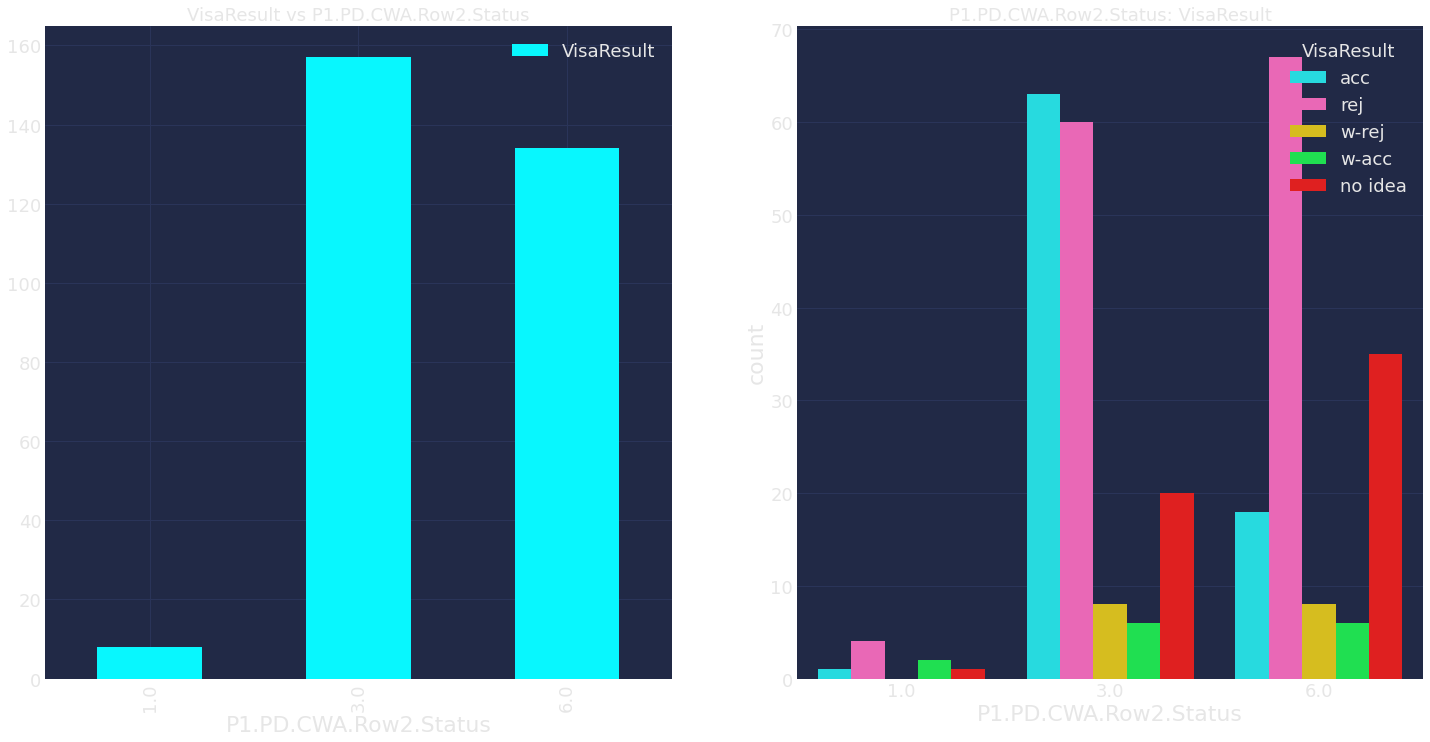

In [68]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

The interesting observation is that there is huge difference between who choose state of their visit to CWA as VISITOR=3 vs OTHER(Biometric)=6. *I think the reason is that those who choose visitor are way richer on average*, because they need to at least stay there for 2 weeks which costs far more than Biometric visit. Let's see if we are right in the following cells:

In [69]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Status', 'P1.PD.CWA.Row2.Period'

pd.crosstab([data[feature_name[0]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name]], data[feature_name[1]],
            margins=True, dropna=False).style.background_gradient(cmap='summer_r')

In [70]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Status', 'P1.PD.CWA.Row2.Period'
data.groupby([*feature_name, output_name])[output_name].count()

P1.PD.CWA.Row2.Status  P1.PD.CWA.Row2.Period  VisaResult
1.0                    30.0                   acc            1
                                              rej            3
                       31.0                   rej            1
                                              w-acc          2
                       90.0                   no idea        1
                                                            ..
6.0                    90.0                   rej           15
                                              w-acc          1
                       92.0                   rej           14
                                              w-rej          1
                       93.0                   rej            1
Name: VisaResult, Length: 54, dtype: int64

### Fill CWA NaN and 0 periods with a heuristic
We could go with average, but apparently data is more like discrete where applicants stayed in months rather than weeks/days. Hence, `mode` is a better feature than `mean` as it falls to dominating value.

In [71]:
data.loc[(data[feature_name[1]] == 0) | (data[feature_name[1]].isna()), feature_name[1]] = data[data[feature_name[1]] != 0][feature_name[1]].mode()
data[feature_name[1]].unique()

array([30., 31., 29., 92., 89., 28., 90., nan, 91., 77., 93., 61., 37.])

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


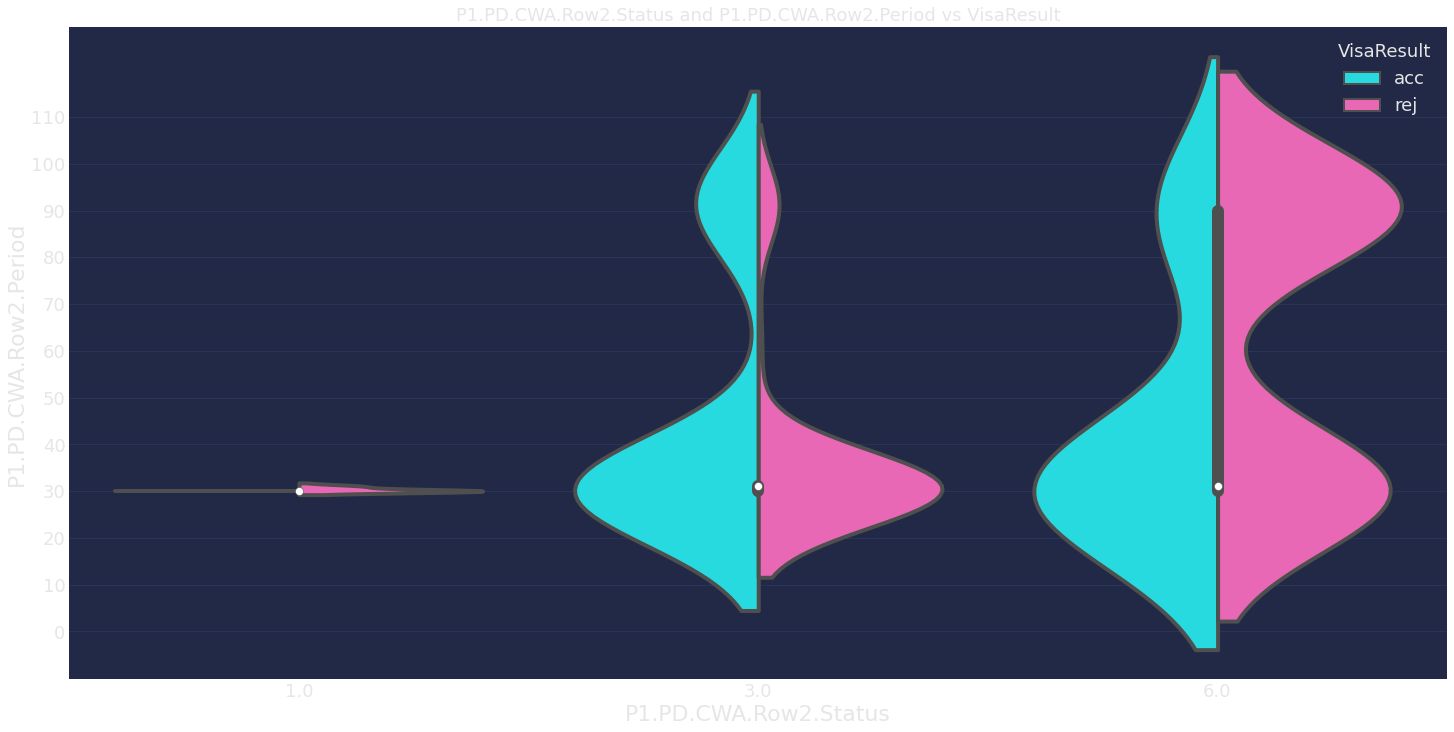

In [72]:
f, ax = plt.subplots(1, 1, figsize=(22, 12))
sns.violinplot(feature_name[0], feature_name[1], hue=output_name, scale='width',
               data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], split=True, ax=ax)
ax.set_title('{} and {} vs {}'.format(
    feature_name[0], feature_name[1], output_name))
ax.set_yticks(range(0, 120, 10))
plt.show()

Well, I WAS WRONG. For some reason, where CWA status is `'OTHER'`, people are mostly staying for 90 days, meanwhile for status of Visitor, the duration is mostly around 30 days. The reason it's weird is that usually CWA status of `'OTHER'` stands for `'Biometric'` case and 90 days mode does not make sense!

TODO: what's going on? ask agents!

### P1.PD.CWA.Row2.Other -> categorical

In [73]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Other'
data.groupby([feature_name, 'P1.PD.CWA.Row2.Status'])[
    output_name].count()

P1.PD.CWA.Row2.Other  P1.PD.CWA.Row2.Status
False                 1.0                        8
                      3.0                      157
                      6.0                       15
True                  6.0                      119
Name: VisaResult, dtype: int64

All the cases that have flag `'P1.PD.CWA.Row2.Other'=True` are in  `'P1.PD.CWA.Row2.Status'=6` which means status of 6 is already representing other case. So, we delete it.

In [74]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P1.MS.SecA.MS -> categorical

In [75]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.MS'
data.groupby([feature_name, output_name])[output_name].count()

P1.MS.SecA.MS  VisaResult
01             acc           65
               no idea       48
               rej           95
               w-acc         12
               w-rej         11
02             acc           10
               no idea        7
               rej           29
               w-acc          2
               w-rej          5
04             acc            5
               no idea        1
               rej            5
06             acc            2
               rej            2
Name: VisaResult, dtype: int64

In [76]:
# convert numbers to names
ms_num_names = {
    '01': 'married',
    '02': 'single',
    '03': 'common-law',
    '04': 'divorced',
    '05': 'separated',
    '06': 'widowed',
    '09': 'annulled',
    '00': 'ukn',
}

data[feature_name] = data[feature_name].apply(lambda x: ms_num_names[x]
                                              if x in ms_num_names else 'ukn')


/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


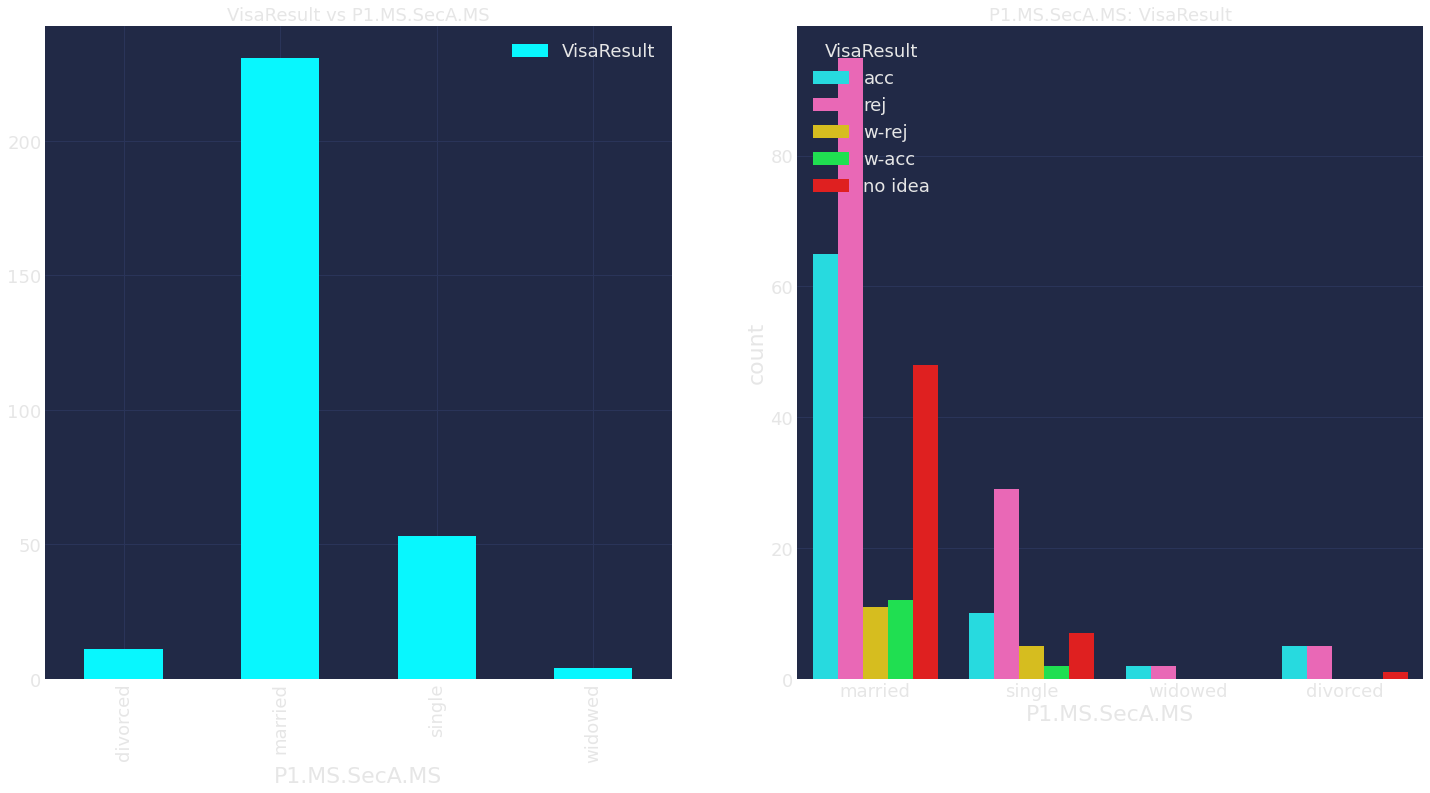

In [77]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


It is clear that *single people (necessarily those who have never married) are way more likely to get rejected*, since single people are way more likely to stay. 

### P2.MS.SecA.PrevMarrIndicator -> categorical

In [78]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.PrevMarrIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P2.MS.SecA.PrevMarrIndicator  VisaResult
False                         acc            69
                              no idea        53
                              rej           123
                              w-acc          14
                              w-rej          14
True                          acc            13
                              no idea         3
                              rej             8
                              w-rej           2
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


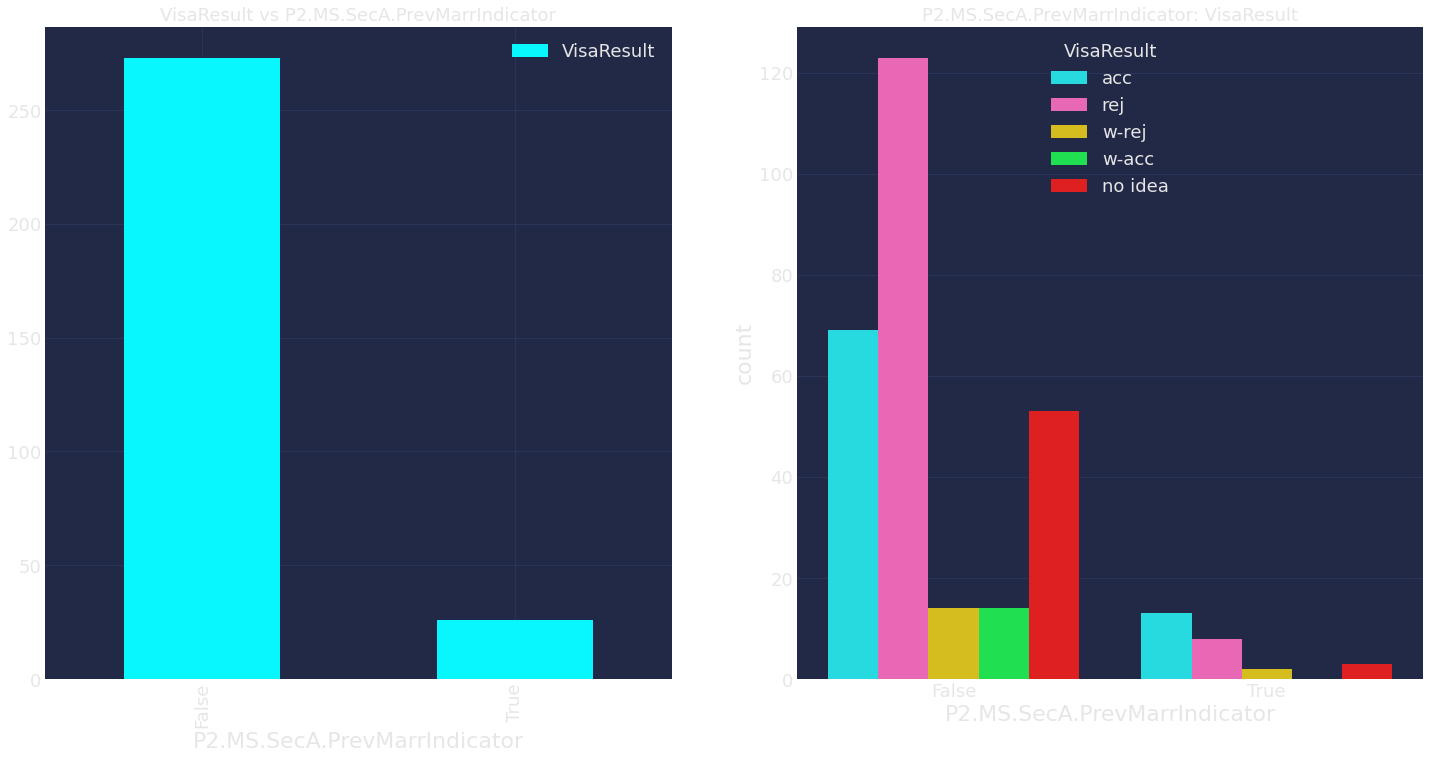

In [79]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


We can see that those who have previous marriage have higher chance, but this could be directly because of the age, since someone with previous marriage is probably more like to have higher age, and higher income (well, women get a lot of money for getting divorced for some unknown reason and those who can divorce usually have higher status as it is rarer to happen in traditional families.)

In [80]:
feature_name = 'P2.MS.SecA.PrevMarrIndicator', 'P1.PD.Sex.Sex'

pd.crosstab([data[feature_name[0]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name]], data[feature_name[1]],
            margins=True, dropna=False).style.background_gradient(cmap='summer_r')

### P2.MS.SecA.TypeOfRelationship -> categorical

In [81]:
# convert numbers to names
ms_num_names = {
    '01': 'married',
    '02': 'single',
    '03': 'common-law',
    '04': 'divorced',
    '05': 'separated',
    '06': 'widowed',
    '09': 'annulled',
    '00': 'ukn',
}

output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.TypeOfRelationship'

data[feature_name] = data[feature_name].apply(lambda x: ms_num_names[x]
                                              if x in ms_num_names else 'ukn')  # keep it 'ukn' since we have this category in XFA PDFs too
                                                                                #   although here it means that there was no previous marriage.

data.groupby([feature_name, output_name])[output_name].count()

P2.MS.SecA.TypeOfRelationship  VisaResult
married                        acc            13
                               no idea         3
                               rej             8
                               w-rej           2
ukn                            acc            69
                               no idea        53
                               rej           123
                               w-acc          14
                               w-rej          14
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


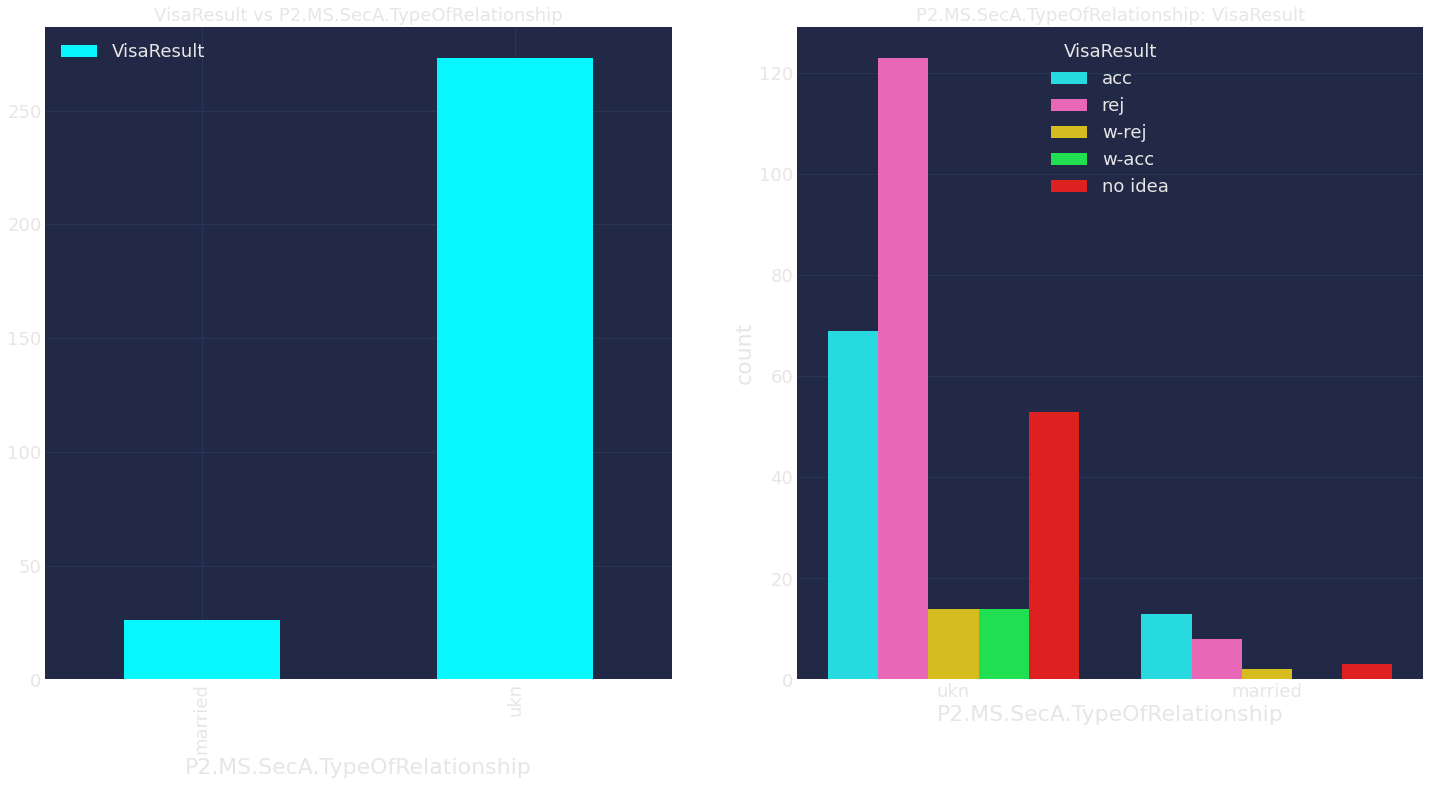

In [82]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


Since we have only type of `'married'`, `'ukn'` represents cases where there was no previous marriage. Hence, feature in previous section, i.e. `'P2.MS.SecA.PrevMarrIndicator'` is representing the exact same thing. On the other hand, common-law marriage is not legal in Iran and as we can see, there is not a single case of it. So even in future, we can just ignore it or replace it with married case. So, we can delete it.

In [83]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue -> categorical

In [84]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue'
data.groupby([feature_name, output_name])[output_name].count()

P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue  VisaResult
059                                             rej             1
IRAN                                            acc            82
                                                no idea        56
                                                rej           128
                                                w-acc          14
                                                w-rej          16
TURKEY                                          rej             2
Name: VisaResult, dtype: int64

In [85]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Langs.languages.nativeLang.nativeLang -> categorical

In [86]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Langs.languages.nativeLang.nativeLang'
data.groupby([feature_name, output_name])[output_name].count()

P2.MS.SecA.Langs.languages.nativeLang.nativeLang  VisaResult
106                                               rej             1
251                                               rej             4
                                                  w-rej           1
IRAN                                              acc            82
                                                  no idea        56
                                                  rej           126
                                                  w-acc          14
                                                  w-rej          15
Name: VisaResult, dtype: int64

In [87]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate -> categorical

In [88]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate'
data.groupby([feature_name, output_name])[output_name].count()

P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate  VisaResult
Both                                                            w-rej           1
English                                                         acc            75
                                                                no idea        55
                                                                rej           130
                                                                w-acc          14
                                                                w-rej          14
Neither                                                         acc             7
                                                                no idea         1
                                                                rej             1
                                                                w-rej           1
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


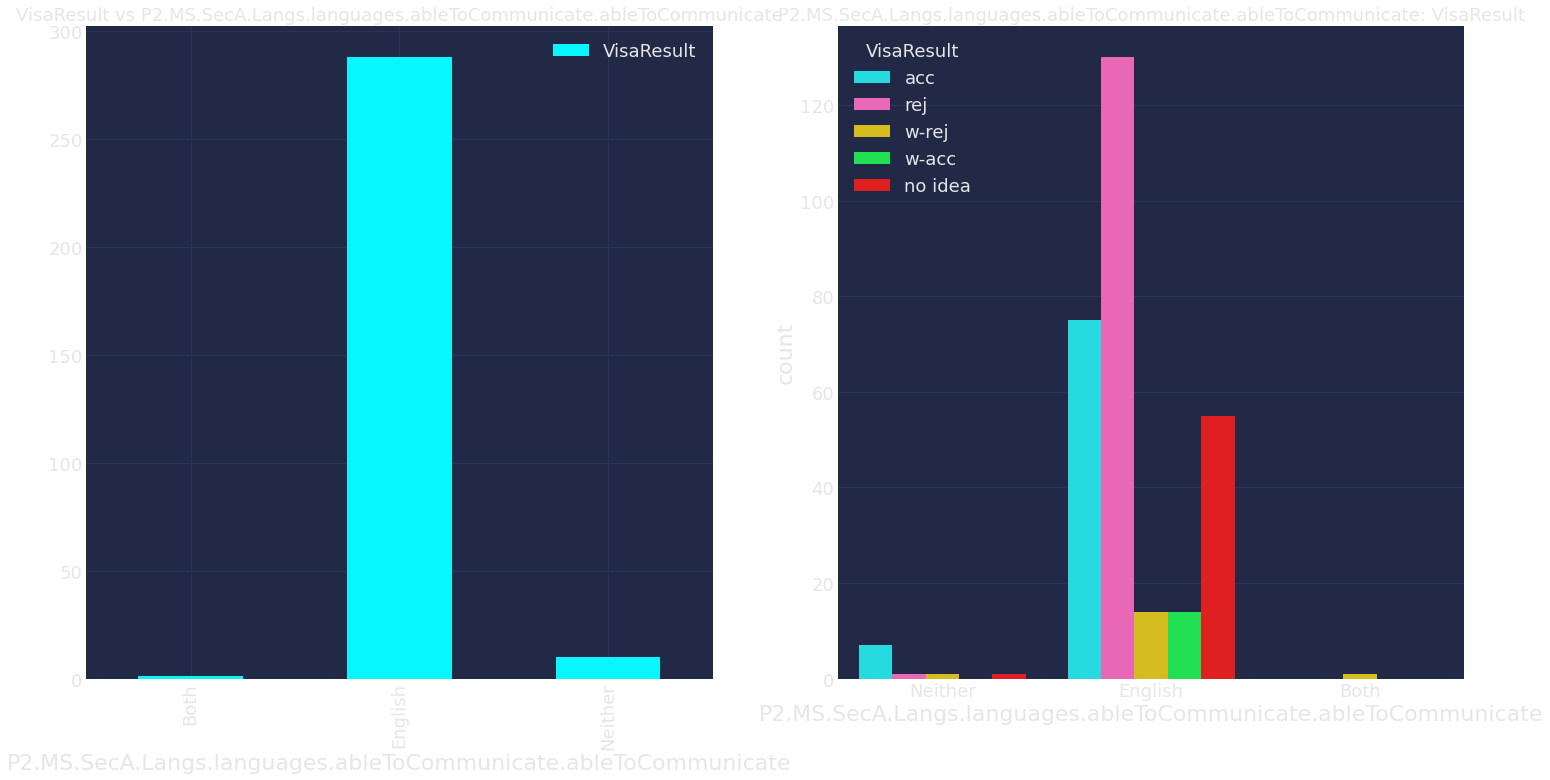

In [89]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


The data is too small to make a decision, but we see a large acceptance rate when applicant speaks no language, and the reason easily could be that the person is probably old and have a full family, i.e. who can afford to go to Canada but does not speak a second language? Old housewives and retired employees probably! Let's see if we are right for fun:

In [90]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow1.Occ.Occ', 'P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate'
data[data[feature_name[1]] == 'Neither'].groupby([*feature_name, output_name])[output_name].count()

P3.Occ.OccRow1.Occ.Occ         P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate  VisaResult
Advertising Director           Neither                                                         no idea       1
DEPUTY OF NOTARY PUBLIC        Neither                                                         rej           1
HOUSEWIFE                      Neither                                                         acc           2
                                                                                               w-rej         1
OWNER RESTAURANT-MASTER CHEF   Neither                                                         acc           1
PERSIAN/PICTURE CARPET WEAVER  Neither                                                         acc           1
RETIRED                        Neither                                                         acc           3
Name: VisaResult, dtype: int64

We were right, KEKW. But it has no useful information since it is directly affected by age, family status, etc. Hence, I delete it.

In [91]:
# drop useless
feature_name = 'P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate'
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Langs.LangTest -> categorical

In [92]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Langs.LangTest'
data.groupby([feature_name, output_name])[output_name].count()

P2.MS.SecA.Langs.LangTest  VisaResult
False                      acc            80
                           no idea        56
                           rej           128
                           w-acc          14
                           w-rej          14
True                       acc             2
                           rej             3
                           w-rej           2
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


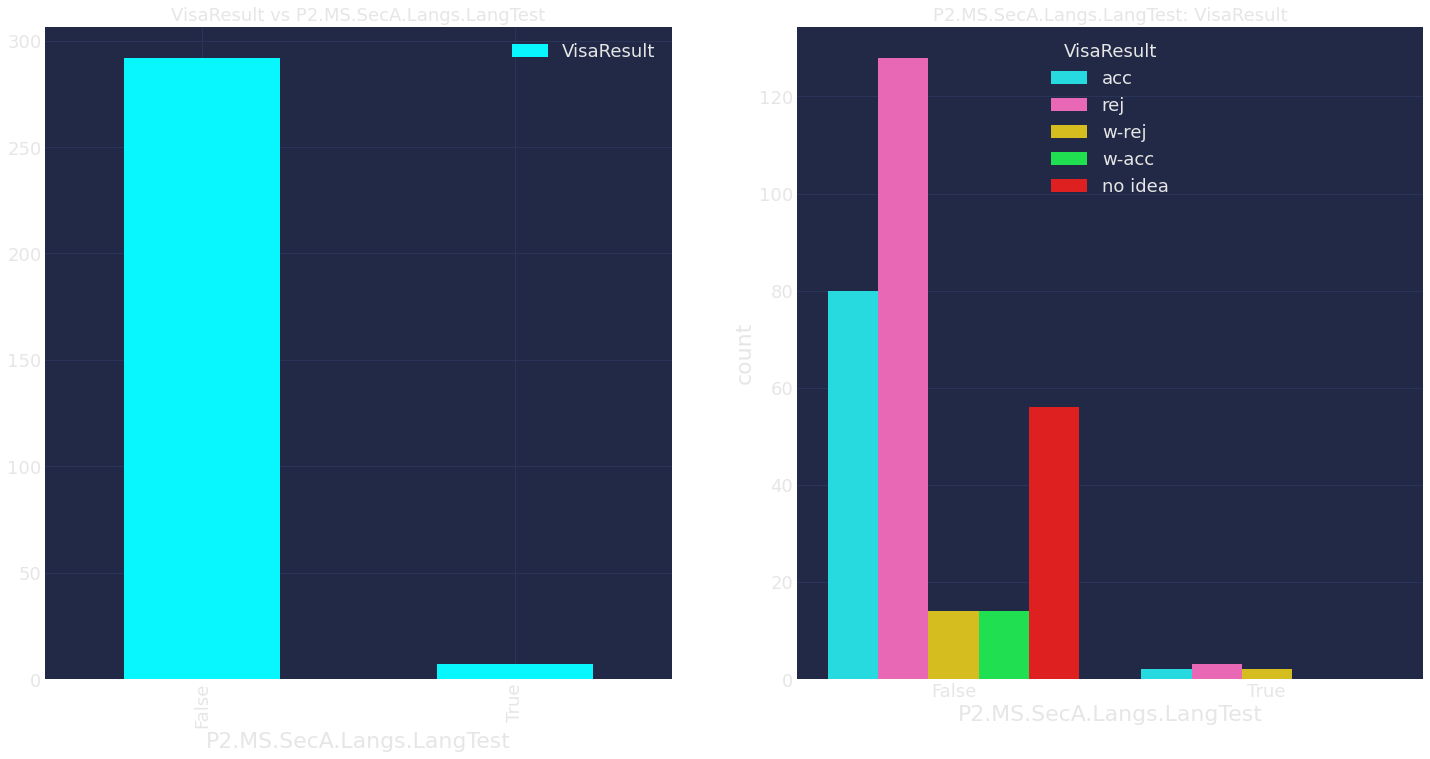

In [93]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

In [94]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

No idea! Maybe letter we can see some correlation or delete it entirely. For now, we delete it because of few samples. TODO: see what's the best, delete or not?

### P2.natID.q1.natIDIndicator -> categorical

In [95]:
output_name = 'VisaResult'
feature_name = 'P2.natID.q1.natIDIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P2.natID.q1.natIDIndicator  VisaResult
True                        acc            82
                            no idea        56
                            rej           131
                            w-acc          14
                            w-rej          16
Name: VisaResult, dtype: int64

In [96]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)
# also this
feature_name = 'P2.natID.natIDdocs.CountryofIssue.CountryofIssue'
data.drop(feature_name, axis=1, inplace=True)

### P2.USCard.q1.usCardIndicator -> categorical

In [97]:
output_name = 'VisaResult'
feature_name = 'P2.USCard.q1.usCardIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P2.USCard.q1.usCardIndicator  VisaResult
False                         acc            82
                              no idea        56
                              rej           131
                              w-acc          14
                              w-rej          16
Name: VisaResult, dtype: int64

In [98]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P2.CI.cntct.PhnNums.[Phn.CanadaUS, AltPhn.CanadaUS] -> categorical

In [99]:
output_name = 'VisaResult'
feature_name = 'P2.CI.cntct.PhnNums.Phn.CanadaUS'
data.groupby([feature_name, output_name])[output_name].count()

P2.CI.cntct.PhnNums.Phn.CanadaUS  VisaResult
False                             acc            82
                                  no idea        56
                                  rej           131
                                  w-acc          14
                                  w-rej          16
Name: VisaResult, dtype: int64

In [100]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)


In [101]:
output_name = 'VisaResult'
feature_name = 'P2.CI.cntct.PhnNums.AltPhn.CanadaUS'
data.groupby([feature_name, output_name])[output_name].count()


P2.CI.cntct.PhnNums.AltPhn.CanadaUS  VisaResult
False                                acc            80
                                     no idea        56
                                     rej           131
                                     w-acc          14
                                     w-rej          16
True                                 acc             2
Name: VisaResult, dtype: int64

In [102]:
data[data[feature_name] == True]

,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row3.Country,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P2.CI.cntct.PhnNums.AltPhn.CanadaUS,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Other.Other,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Occ.Occ,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Occ.Occ,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Occ.Occ,P3.Occ.OccRow3.Country.Country,P3.BGI.Details.MedicalDetails,P3.BGI.otherThanMedic,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P3.PWrapper.criminalRec,P3.PWrapper.Military.Choice,P3.PWrapper.politicViol,P3.PWrapper.witnessIllTreat,P1.PD.CurrCOR.Row2.Period,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.PrevSpouseDOB.DOBYear.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult,P1.PD.PrevCOR.Row.Count
55,False,Female,IRAN,1.0,1.429856,1.429856,False,TURKEY,3.0,married,False,True,8.0,False,8000.0,DAUGHTER,OTHER,False,IRAN,RETIRED,IRAN,OTHER,IRAN,OTHER,IRAN,False,False,False,False,False,False,False,False,False,26497.0,26497.0,0.0,0.0,91.0,18309.0,0.0,0.0,1496.0,31.0,0.0,7139.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,IRAN,RETIRED,True,IRAN,DECEASED,False,9.0,IRAN,DECEASED,False,9.0,5.0,DAUGHTER,IRAN,EMPLOYEE,False,9.0,OTHER,IRAN,OTHER,False,9.0,OTHER,IRAN,OTHER,False,9.0,OTHER,IRAN,OTHER,False,5.0,BROTHER,IRAN,RETIRED,False,5.0,BROTHER,IRAN,RETIRED,False,5.0,SISTER,IRAN,RETIRED,False,5.0,SISTER,IRAN,RETIRED,False

In [103]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)


These two entries are the family of the same person with strong application. Although, indication of Canada/US phone depicts strong case, other factors should indicate the same thing too, like previous travel to Canada/US, funds, relationship in Canada, etc. Hence, I remove it for now until further notice!

TODO: see if del or not

### P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit -> categorical

In [104]:
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'
data.groupby([feature_name, output_name])[output_name].count()

P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  VisaResult
1.0                                      rej            1
2.0                                      acc           28
                                         no idea       32
                                         rej           86
                                         w-acc          7
                                         w-rej          8
3.0                                      acc            1
                                         rej            2
8.0                                      acc           48
                                         no idea        6
                                         rej           23
                                         w-acc          4
                                         w-rej          3
13.0                                     acc            5
                                         no idea       18
                                         rej           19
                    

In [105]:
# convert numbers to names
vp_num_names = {
    1: 'business',
    2: 'tourism',
    3: 'other',
    4: 'short study',
    5: 'returning student',
    6: 'returning worker',
    7: 'super visa',
    8: 'family visit',
    13: 'visit',
}

output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'
data[feature_name] = data[feature_name].apply(lambda x: vp_num_names[int(x)]
                                              if int(x) in vp_num_names else 'other')
# keep it 'other' since we have this category in XFA PDFs too (as '03')
#   although here it means that there was no previous marriage.

data.groupby([feature_name, output_name])[output_name].count()


P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  VisaResult
business                                 rej            1
family visit                             acc           48
                                         no idea        6
                                         rej           23
                                         w-acc          4
                                         w-rej          3
other                                    acc            1
                                         rej            2
tourism                                  acc           28
                                         no idea       32
                                         rej           86
                                         w-acc          7
                                         w-rej          8
visit                                    acc            5
                                         no idea       18
                                         rej           19
                    

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


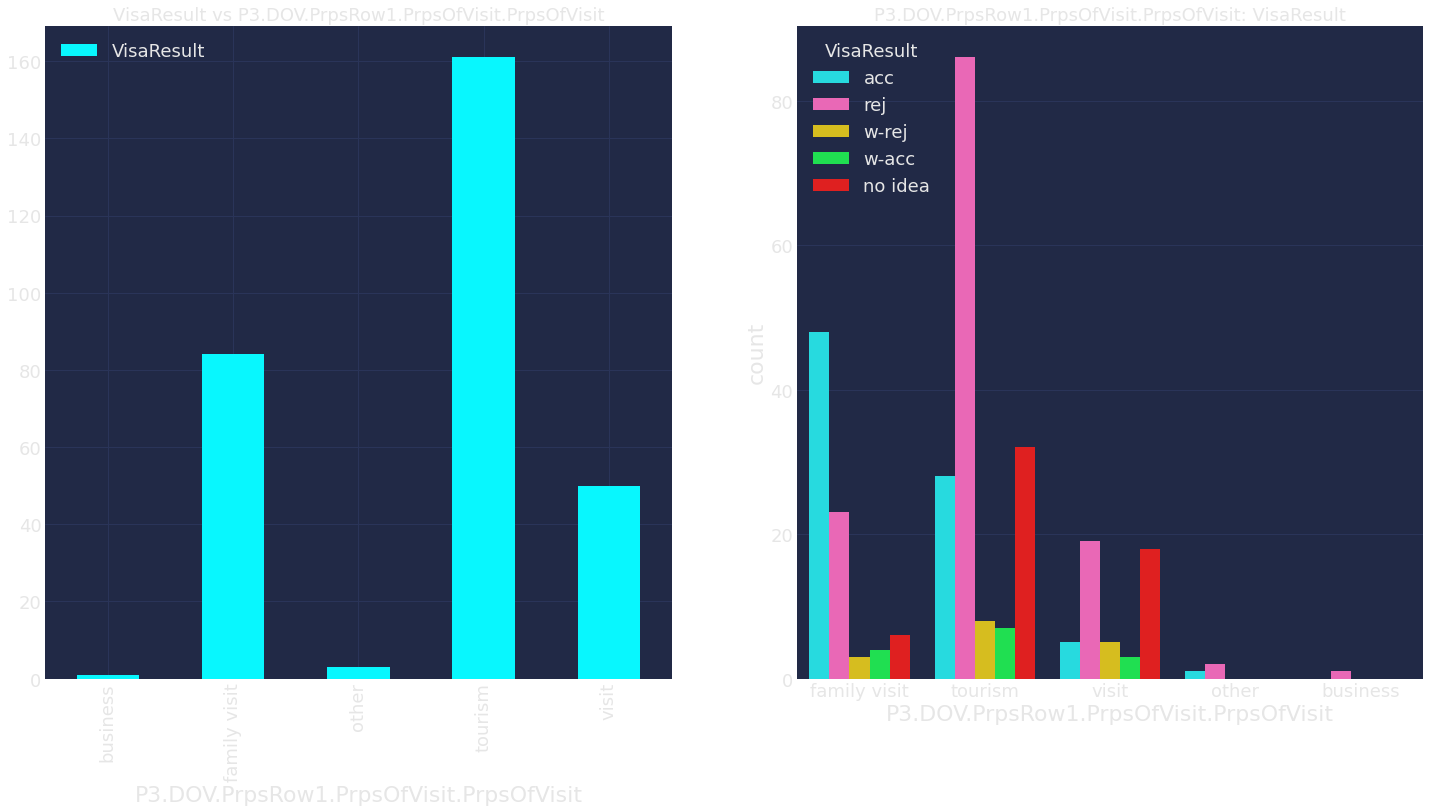

In [106]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


Clearly, a candidate visiting his family (hence having invitation letter too) has a stronger application than just tourism which is open to all. Also, just `'visit'` is not good enough even though it's not `'tourism'`.

In [107]:
feature_name = 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit', 'P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe'

z = data[data[feature_name[0]] == 'visit']

pd.crosstab([z[feature_name[0]], z[(z[output_name] == 'acc') | (z[output_name] == 'rej')][output_name]], z[feature_name[1]],
            margins=True, dropna=False).style.background_gradient(cmap='summer_r')


Well, yes, of course you get rejected if you are going to spend 10K CAD to see your wife's first cousin. OMEGALUL.

### P3.DOV.PrpsRow1.Other.Other -> categorical

In [108]:
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.Other.Other'
data.groupby([feature_name, output_name])[output_name].count()

P3.DOV.PrpsRow1.Other.Other  VisaResult
False                        acc            81
                             no idea        56
                             rej           129
                             w-acc          14
                             w-rej          16
True                         acc             1
                             rej             2
Name: VisaResult, dtype: int64

In [109]:
data[data[feature_name] == True].groupby(
    ['P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit', feature_name])[feature_name].count()


P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  P3.DOV.PrpsRow1.Other.Other
other                                    True                           3
Name: P3.DOV.PrpsRow1.Other.Other, dtype: int64

In [110]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)


### P3.DOV.PrpsRow1.Funds.Funds -> Continuous

count      299.000000
mean      9051.839465
std       2050.083063
min       1000.000000
25%       8000.000000
50%      10000.000000
75%      10000.000000
max      30000.000000
Name: P3.DOV.PrpsRow1.Funds.Funds, dtype: float64


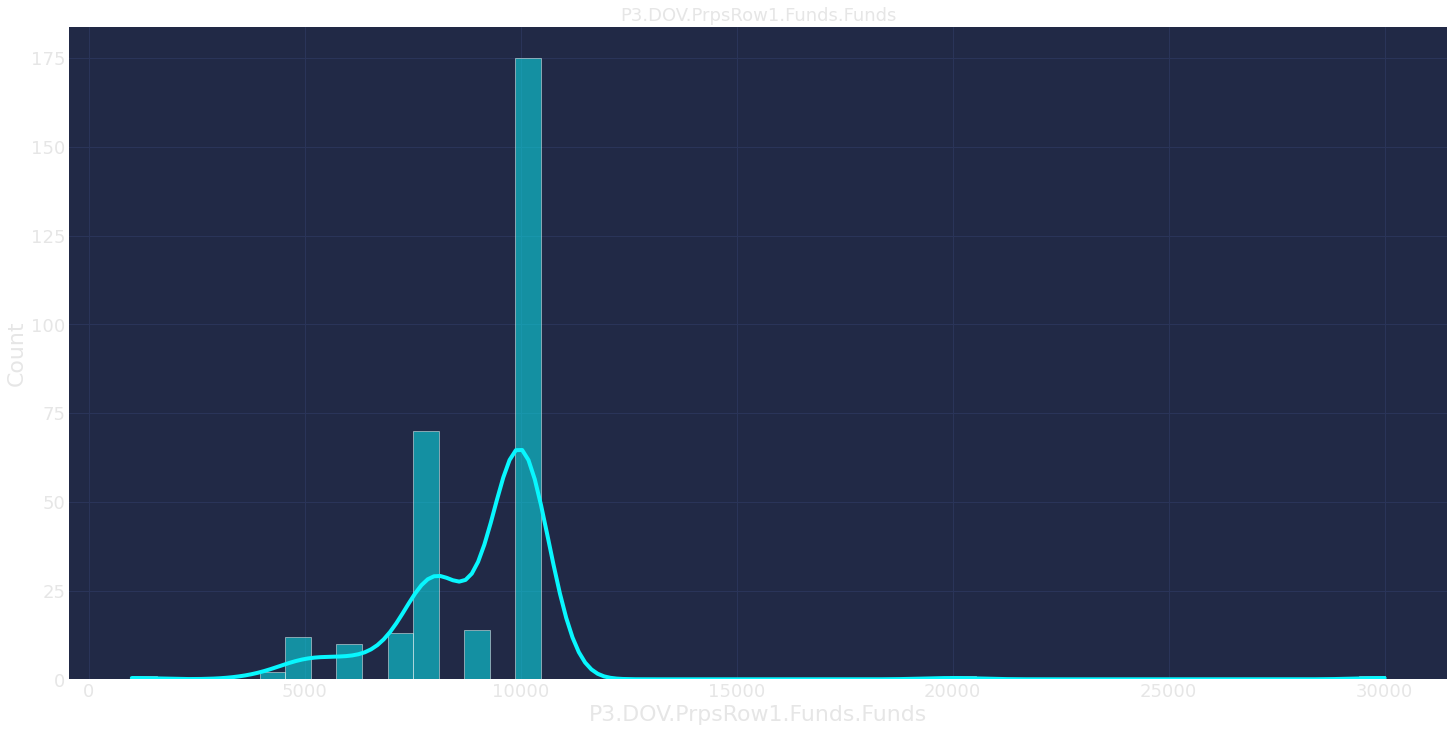

In [111]:
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.Funds.Funds'

print(data[feature_name].describe())

f, ax = plt.subplots(1, 1, figsize=(22, 12))
sns.histplot(data[feature_name], ax=ax, kde=True)
ax.set_title('{}'.format(feature_name))
plt.show()


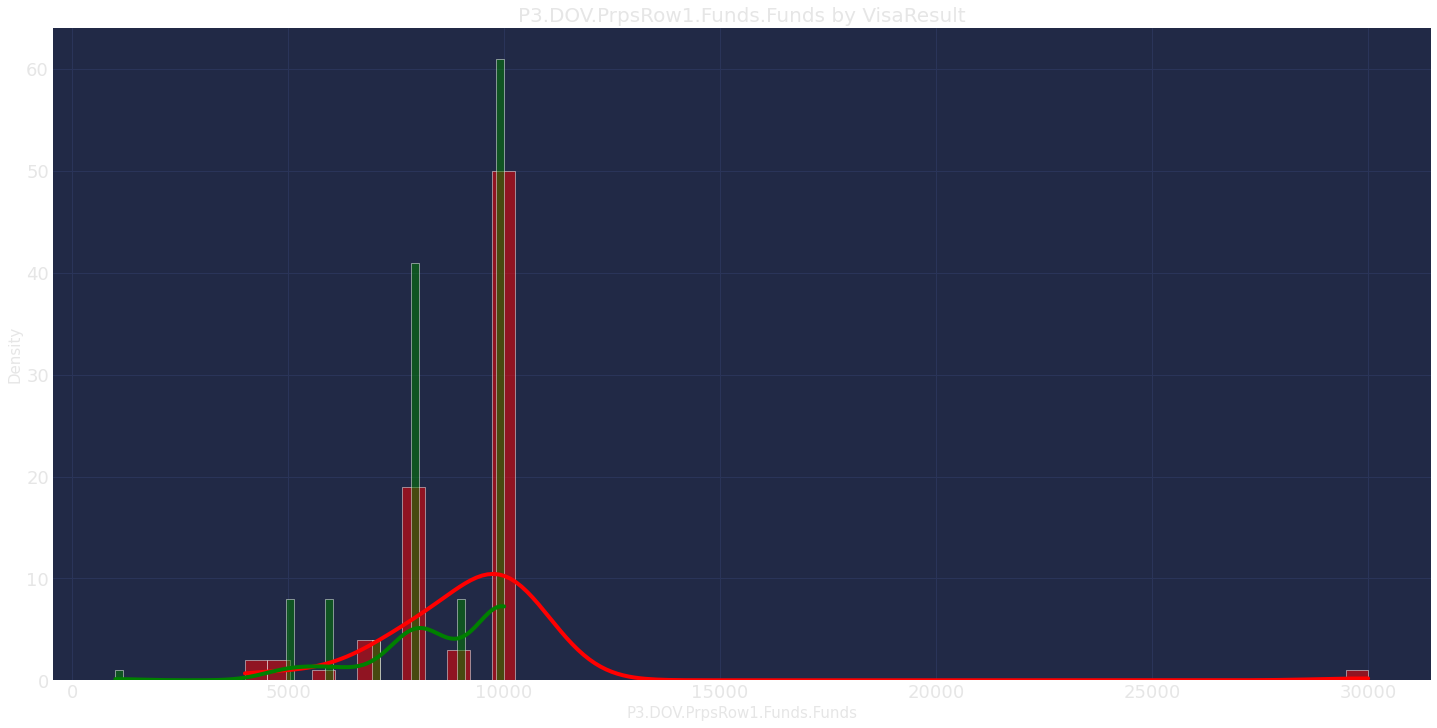

In [112]:
plt.figure(figsize=(22, 12))

sns.histplot(data[data[output_name] == 'acc'][feature_name],
             bins=50, color='r', kde=True)
sns.histplot(data[data[output_name] == 'rej'][feature_name],
             bins=50, color='g', kde=True)
plt.title('{} by {}'.format(feature_name, output_name), fontsize=20)
plt.xlabel(feature_name, fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()


### P3.DOV.cntcts_Row[i].RelationshipToMe.RelationshipToMe -> categorical

In [113]:
output_name = 'VisaResult'
feature_name = 'P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe', 'P3.cntcts_Row2.Relationship.RelationshipToMe'

print(data[feature_name[0]].unique())
print(data[feature_name[1]].unique())

['SON' 'OTHER' 'HOTEL' 'DAUGHTER' 'RELATIVE-FREIND' 'AUNT' 'BROTHER'
 'COUSIN' 'HOTE' 'sister' 'Hotel' 'SISTER'
 'CEO TOTAL ARM WRESTLING LEAGUE' 'sister in law' 'Aunt'
 'SON-DAUGHTER IN LAW' 'My First Cousin' 'PARENT AND SISTER'
 'BROTHER IN LAW' '1)SON-IN-LAW' 'FRIEND' 'CHILD' 'GRANDCHILD' 'MOTHER'
 'hotel' 'DAUGHTER-SON IN LAW' 'BROTHER-IN-LAW'
 'SISTER IN LAW-MY WIFE SISTER' 'Close Friend' 'STEP SON' 'WIFE\\\\S AUNT'
 'IFBB PRO LEAGUE' 'SISTER IN LAW' 'UNCLE' 'Wife\\\\s Aunt'
 'MY WIFE\\\\S COUSIN' 'CLOSE FRIEND' 'My Wife\\\\s first cousin' 'NIECE'
 'STEP BROHER' 'WIFE\\\\S SISTER'
 'INTERNATIONAL SYMPOSIUM OF SCULPTURE- HOTEL' 'TWIN BROTHER' 'NEPHEW']
['OTHER' 'HOTEL' 'COUSIN,S HUSBAND' 'Hotel' 'cousin'
 'My First Cousin\\\\s Husband/hotel' '2)DAUGHTER' 'BROTHER-IN-LAW'
 'FRIEND' 'hotel' 'SON IN LAW' 'SPOUSE\\\\S SISTER\\\\S HUSBAND'
 'Close Friend' 'DAUGHTER IN LAW' 'COUSIN' '2)HOTEL 3)CLOSE FRIEND'
 'SON IN LOW' 'WIFE\\\\S COUSIN' 'SISTER IN LAW' 'SISTER'
 'The Husband of My Wif

We need to categorize these into simpler and representative categories:
1. `['brother', 'sister', 'step*', ...]: 'f1'` 
2. `['*in law*', 'nephew']: 'f2'`
3.  `'*friend*': 'friend'`


Issues:
1. Should we put `'hotel'` first or `'cousin'` in `'The Husband of My Wife\\\\s first cousin/hotel'`?  TODO: ask agents which one has higher priority

In [114]:
rel_cat = {  # order matters, put weaker on top, i.e. put 'law' above 'brother', so 'brother in law' get handled by 'law' rule than 'bother' rule
    'law': 'f2',
    'nephew': 'f2',
    'niece': 'f2',
    'aunt': 'f2',
    'uncle': 'f2',
    'cousin': 'f2',
    'relative': 'f2',
    'grand': 'f2',
    'parent': 'f1',
    'mother': 'f1',
    'father': 'f1',
    'child': 'f1',
    'daughter': 'f1',
    'brother': 'f1',
    'sister': 'f1',
    'wife': 'f1',
    'husband': 'f1',
    'step': 'f1',
    'son': 'f1',
    'partner': 'f1',
    'fiance': 'f1',
    'fiancee': 'f1',
    'other': 'ukn',
    'friend': 'friend',
    'league': 'work',
    'symposium': 'work',
    'hote': 'hotel',
    'hotel': 'hotel',
}


def fix_rel(string: str, dic: dict):
    string = string.lower()
    for k, v in dic.items():
        if k in string:
            string = string.replace(string, v)
            return string
    return 'ukn'


data[feature_name[0]] = data[feature_name[0]].apply(fix_rel, args=(rel_cat, ))
data[feature_name[1]] = data[feature_name[1]].apply(fix_rel, args=(rel_cat, ))


In [115]:
print(data[feature_name[0]].unique())
print(data[feature_name[1]].unique())


['f1' 'ukn' 'hotel' 'f2' 'work' 'friend']
['ukn' 'hotel' 'f2' 'f1' 'friend']


/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


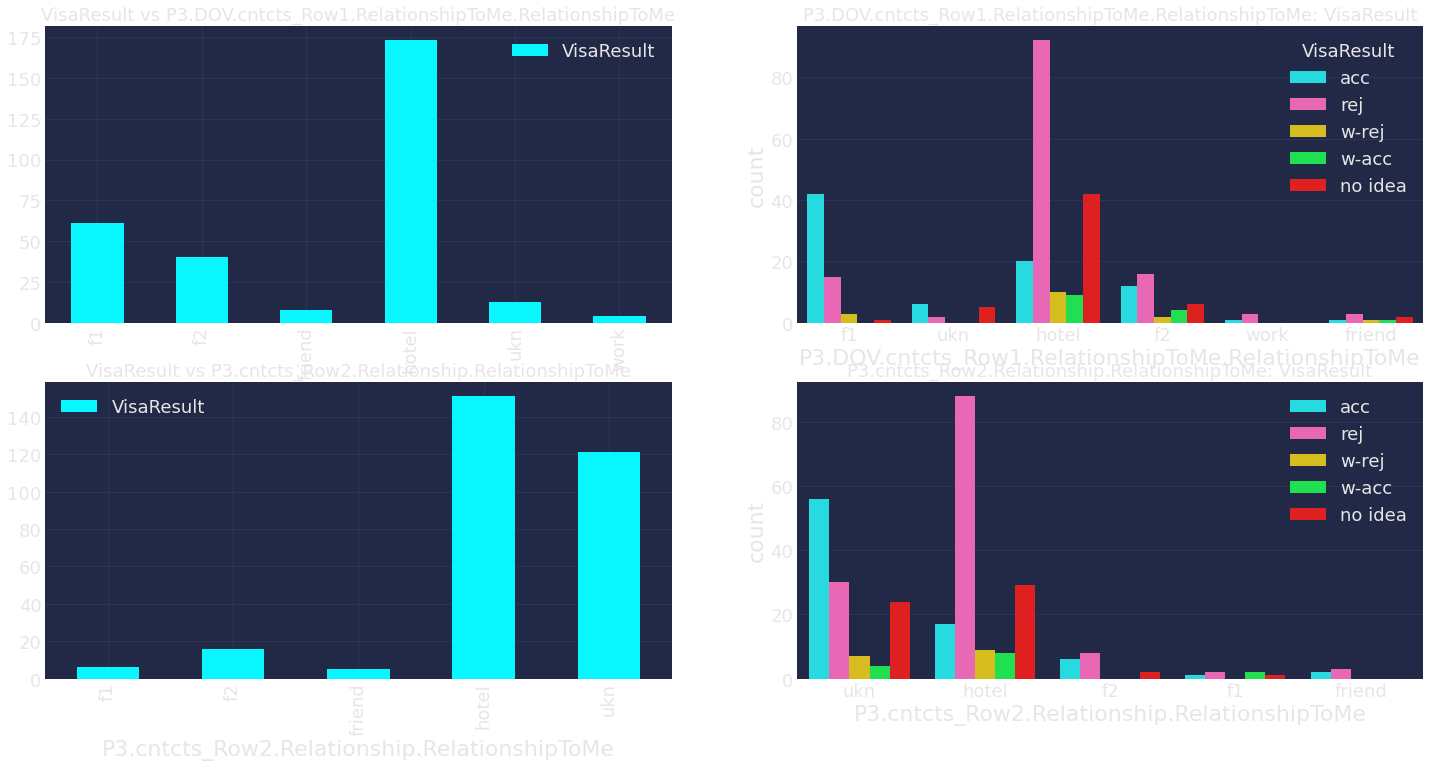

In [116]:
f, ax = plt.subplots(2, 2, figsize=(22, 12))
data[[feature_name[0], output_name]].groupby(
    [feature_name[0]]).count().plot.bar(ax=ax[0, 0], sort_columns=True)
ax[0, 0].set_title('{} vs {}'.format(output_name, feature_name[0]))
sns.countplot(feature_name[0], hue=output_name, data=data,
              ax=ax[0, 1], hue_order=output_hue_order)
ax[0, 1].set_title('{}: {}'.format(feature_name[0], output_name))

data[[feature_name[1], output_name]].groupby(
    [feature_name[1]]).count().plot.bar(ax=ax[1, 0], sort_columns=True)
ax[1, 0].set_title('{} vs {}'.format(output_name, feature_name[1]))
sns.countplot(feature_name[1], hue=output_name, data=data,
              ax=ax[1, 1], hue_order=output_hue_order)
ax[1, 1].set_title('{}: {}'.format(feature_name[1], output_name))
ax[1, 1].legend(loc='upper right')
plt.show()


### P3.Edu.EduIndicator -> categorical

In [117]:
output_name = 'VisaResult'
feature_name = 'P3.Edu.EduIndicator'
data.groupby([feature_name, output_name])[output_name].count()

P3.Edu.EduIndicator  VisaResult
False                acc           29
                     no idea       14
                     rej           42
                     w-acc          7
                     w-rej          5
True                 acc           53
                     no idea       42
                     rej           89
                     w-acc          7
                     w-rej         11
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


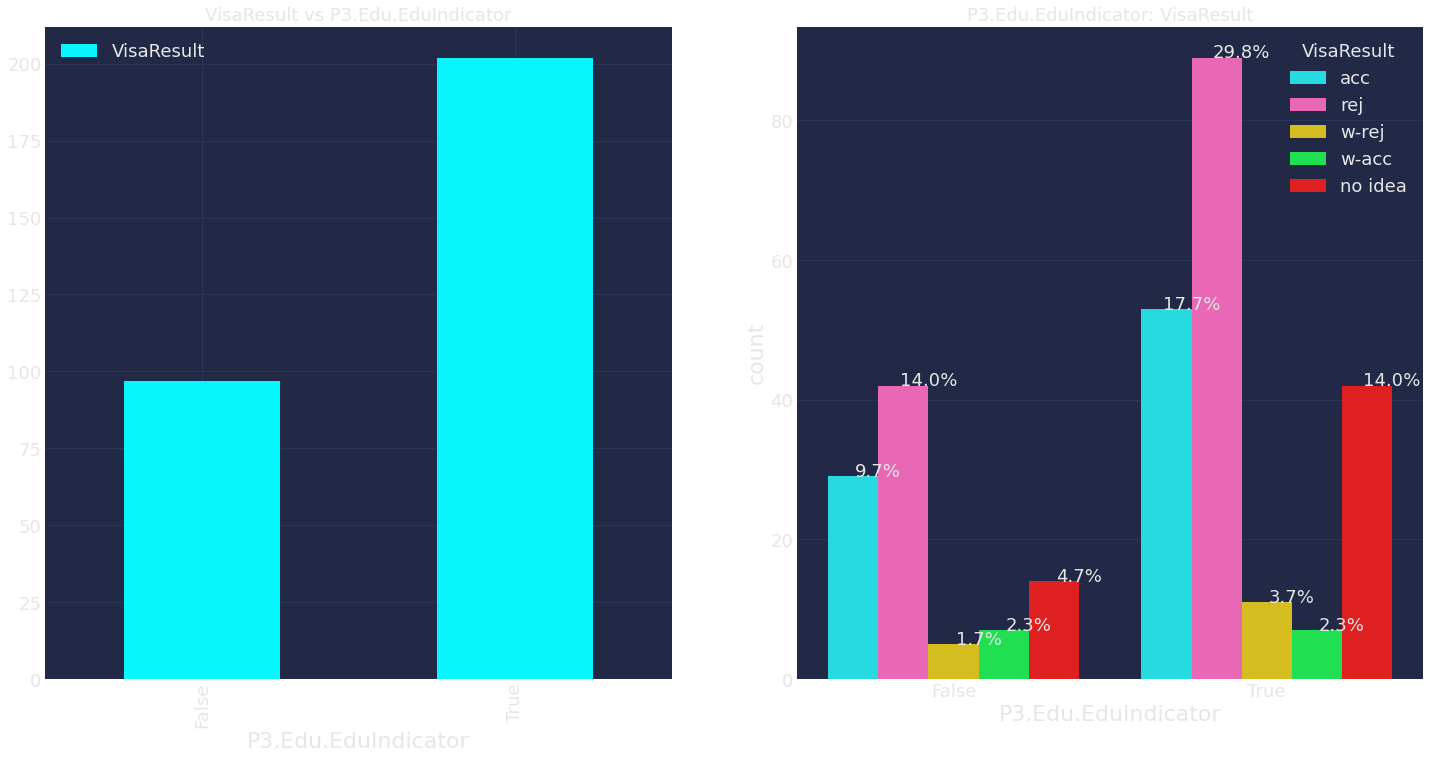

In [118]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
for p in ax[1].patches:  # https://stackoverflow.com/a/63479557/18971263
    percentage = '{:.1f}%'.format(100 * p.get_height()/float(len(data)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax[1].annotate(percentage, (x, y), ha='center')
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


It seems that around %40 of people without education got accepted but %37.5 of people with education got accepted. These percentages are close and other factors such as age might have greater effect.

Also, I think the education field has way more effect than just having higher education. Of course we prefer a engineer/medic refugee than some pleb that going to consume more than provide.

TODO: somehow categorize education level/field into an ordered list, then show the acceptance rate given the education level/field.

### P3.Edu.Edu_Row1.Country.Country -> categorical -> continuous

In [119]:
output_name = 'VisaResult'
feature_name = 'P3.Edu.Edu_Row1.Country.Country'
data.groupby([feature_name, output_name])[output_name].count()

P3.Edu.Edu_Row1.Country.Country  VisaResult
028                              acc             2
                                 rej             1
059                              rej             1
242                              acc             1
280                              acc             1
IRAN                             acc            78
                                 no idea        56
                                 rej           129
                                 w-acc          14
                                 w-rej          16
Name: VisaResult, dtype: int64

Dealing with countries in categorical form is not logical. We would like to rank them or in an easier way, have a continuous score for each country. This way, we can convert a possibly large categorical feature into continuous field.

To do so, approach discussed in issue #10 (PR #11) has been taken, which in summary, takes WorldBank data, looks for education fields, and take average of countries score over past years. Here, we utilize those methods.

In [120]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value


def code_search_dict(string: str, dic: dict, if_nan: str):
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        print('"{}" is not numeric ==> SKIPPED'.format(string))
        return string


data[feature_name] = data[feature_name].apply(func=code_search_dict, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', ))


"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not 

For some reason, I filled all `None`'s with `'IRAN'` which is a wrong action. For now, I fix it by setting it to `None` by overlapping `'P3.Edu.Edu_Row1.Country.Country' ` and `'P3.Edu.EduIndicator'`

In [121]:
output_name = 'VisaResult'
feature_name = 'P3.Edu.Edu_Row1.Country.Country' 

print(data[data['P3.Edu.EduIndicator'] == False].__len__() -
      data[data[feature_name].isna()].__len__())  # must be = 0

data.loc[data['P3.Edu.EduIndicator'] == False, feature_name] = None

print(data[data['P3.Edu.EduIndicator'] == False].__len__() -
      data[data[feature_name].isna()].__len__())  # must be = 0


97
0


Time to convert country names to continuous values of scores of them.

In [122]:
tmp_df = pd.read_pickle('../raw-dataset/databank-2015-2019.pkl')
edu_country_score_preprocessor = preprocessor.EducationCountryScoreDataframePreprocessor(
    dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=edu_country_score_preprocessor.convert_country_name_to_numeric)


/home/nik/visaland-visa-form-utility/vizard_utils/preprocessor.py:447: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.drop([self.INDICATOR, self.SUBINDICATOR],
/home/nik/visaland-visa-form-utility/vizard_utils/preprocessor.py:450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[indicator_name + '_mean'] = dataframe.mean(axis=1, skipna=True,
/home/nik/visaland-visa-form-utility/vizard_utils/preprocessor.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

In [123]:
data[data['P3.Edu.EduIndicator'] == False][feature_name].unique()

array([1.])

### P3.Occ.OccRow1.Occ.Occ -> categorical -> continuous

In [124]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow1.Occ.Occ'
# data.groupby([feature_name, output_name])[output_name].count()
data[feature_name].unique()

array(['PERSIAN/PICTURE CARPET WEAVER',
       'CHAIRMAN OF THE BOARD-ADVERTISING MANAGER-', 'MAKEUP ARTIST',
       'APPLICATION DEVELOPMENT MANAGER', 'GENERAL PRACTITIONER',
       'HOUSEWIFE', 'PETROCHEMICAL CO. ENGINEER',
       'PREPARING AND SUPERVISING FOR EXECUTING CONCRETING OPERATION',
       'SALES MANAGER', 'RETIRED', 'EMPLOYEE', 'CHILD',
       'Razi Insurance Manager- Western Province of Mazandaran',
       'UNIVERSITY PROFESSOR', 'Retired',
       'Shareholder of design and implementation ARAD TARH NOVIN company',
       'CHAIRMAN OF THE BOARD AND TECHNICAL MANAGER',
       'TECHNICAL DIRECTOR AND HSE OFICCER', 'CHAIRERSON OPF THE BOARD',
       'Haberdashery, Corrective Lenses and Sunglasses Guild Union of Shemiranat',
       'DEPUTY OF NOTARY PUBLIC', 'SALES SUPERVISOR', 'HOUSE WIFE',
       'PURCHASING MANAGER', 'IMPORT AND EXPORT',
       'BUSINESS LICENCE OWNER-SELLER OF BUILDING HYGIENE INSTRUMENTS AND RADIATORS',
       'HOLDER OF ENGINEERING EORK LICENCE',
      

TODO: fix, for now deleted

This is hard to deal with too, can we assign continuous values? can we rank and categorize into 5, 10 categories?

In [125]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

#### P3.Occ.OccRow2.Occ.Occ -> categorical -> continuous

In [126]:
# drop useless
feature_name = 'P3.Occ.OccRow2.Occ.Occ'
data.drop(feature_name, axis=1, inplace=True)

#### P3.Occ.OccRow3.Occ.Occ -> categorical -> continuous

In [127]:
# drop useless
feature_name = 'P3.Occ.OccRow3.Occ.Occ'
data.drop(feature_name, axis=1, inplace=True)

### P3.Occ.OccRow1.Country.Country -> categorical -> continuous

In [128]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow1.Country.Country'
data.groupby([feature_name, output_name])[output_name].count()

P3.Occ.OccRow1.Country.Country  VisaResult
059                             rej             1
202                             w-rej           1
224                             rej             1
280                             acc             1
IRAN                            acc            81
                                no idea        56
                                rej           129
                                w-acc          14
                                w-rej          15
Name: VisaResult, dtype: int64

Dealing with countries in categorical form is not logical. We would like to rank them or in an easier way, have a continuous score for each country. This way, we can convert a possibly large categorical feature into continuous field.

To do so, approach discussed in issue #10 (PR #11) has been taken, which in summary, takes WorldBank data, looks for economical fields (GDP), and take average of countries score over past years. Here, we utilize those methods.

In [129]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value


def code_search_dict(string: str, dic: dict, if_nan: str):
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        print('"{}" is not numeric ==> SKIPPED'.format(string))
        return string


data[feature_name] = data[feature_name].apply(func=code_search_dict, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', ))


"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not 

Time to convert country names to continuous values of scores of them.

In [130]:
data[feature_name].unique()

array(['IRAN', 'China', 'United Arab Emirates', 'Ukraine', 'Iraq'],
      dtype=object)

options: 
- 'GCI 4.0: Global Competitiveness Index 4.0, Rank'
- [NEW] GDP per capita: https://data.worldbank.org/indicator/NY.GDP.PCAP.CD 

In [131]:
tmp_df = pd.read_pickle('../raw-dataset/API_NY.GDP.PCAP.CD_DS2_en_xml_v2_4004943.pkl')
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [132]:
data[feature_name].unique()

array([1.10715442, 1.32752412, 2.33984284, 1.10558781, 1.16178083])

#### P3.Occ.OccRow2.Country.Country -> categorical -> continuous

In [133]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow2.Country.Country'
data.groupby([feature_name, output_name])[output_name].count()

P3.Occ.OccRow2.Country.Country  VisaResult
059                             rej             1
280                             acc             1
IRAN                            acc            81
                                no idea        56
                                rej           129
                                w-acc          14
                                w-rej          16
TURKEY                          rej             1
Name: VisaResult, dtype: int64

In [134]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value


def code_search_dict(string: str, dic: dict, if_nan: str):
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        print('"{}" is not numeric ==> SKIPPED'.format(string))
        return string


data[feature_name] = data[feature_name].apply(func=code_search_dict, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', ))


"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not 

In [135]:
tmp_df = pd.read_pickle('../raw-dataset/API_NY.GDP.PCAP.CD_DS2_en_xml_v2_4004943.pkl')
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [136]:
data[feature_name].unique()

array([1.10715442, 2.33984284, 1.10558781, 1.30392442])

#### P3.Occ.OccRow3.Country.Country -> categorical -> continuous

In [137]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow3.Country.Country'
data.groupby([feature_name, output_name])[output_name].count()

P3.Occ.OccRow3.Country.Country  VisaResult
059                             rej             1
IRAN                            acc            82
                                no idea        56
                                rej           130
                                w-acc          14
                                w-rej          16
Name: VisaResult, dtype: int64

In [138]:
config_path = '../' + constant.CONFIGS_PATH.CANADA_COUNTRY_CODE_TO_NAME.value


def code_search_dict(string: str, dic: dict, if_nan: str):
    if string.isnumeric():
        return functional.search_dict(string=string, dic=dic, if_nan=if_nan)
    else:
        print('"{}" is not numeric ==> SKIPPED'.format(string))
        return string


data[feature_name] = data[feature_name].apply(func=code_search_dict, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', ))


"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not numeric ==> SKIPPED
"IRAN" is not 

In [139]:
tmp_df = pd.read_pickle('../raw-dataset/API_NY.GDP.PCAP.CD_DS2_en_xml_v2_4004943.pkl')
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [140]:
data[feature_name].unique()

array([1.10715442, 1.10558781])

### P3.BGI.Details.MedicalDetails -> categorical

In [141]:
output_name = 'VisaResult'
feature_name = 'P3.BGI.Details.MedicalDetails'
data.groupby([feature_name, output_name])[output_name].count()

P3.BGI.Details.MedicalDetails  VisaResult
False                          acc            82
                               no idea        56
                               rej           131
                               w-acc          14
                               w-rej          16
Name: VisaResult, dtype: int64

In [142]:
# drop useless
feature_name = 'P3.BGI.Details.MedicalDetails'
data.drop(feature_name, axis=1, inplace=True)

### P3.BGI.otherThanMedic -> categorical

In [143]:
output_name = 'VisaResult'
feature_name = 'P3.BGI.otherThanMedic'
data.groupby([feature_name, output_name])[output_name].count()

P3.BGI.otherThanMedic  VisaResult
False                  acc            82
                       no idea        56
                       rej           131
                       w-acc          14
                       w-rej          16
Name: VisaResult, dtype: int64

In [144]:
# drop useless
feature_name = 'P3.BGI.otherThanMedic'
data.drop(feature_name, axis=1, inplace=True)

### P3.noAuthStay -> categorical

In [145]:
output_name = 'VisaResult'
feature_name = 'P3.noAuthStay'
data.groupby([feature_name, output_name])[output_name].count()

P3.noAuthStay  VisaResult
False          acc            82
               no idea        56
               rej           129
               w-acc          14
               w-rej          16
True           rej             2
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


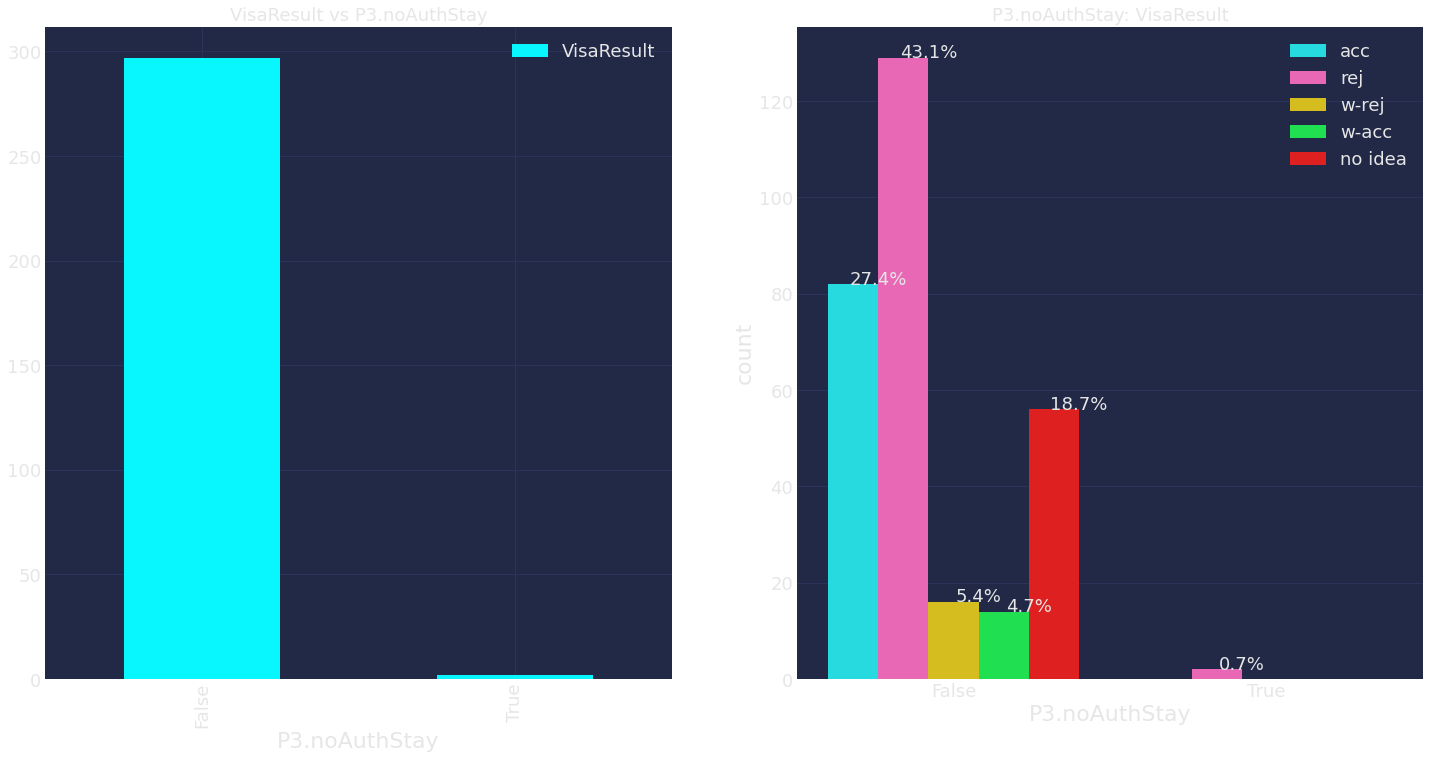

In [146]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
for p in ax[1].patches:  # https://stackoverflow.com/a/63479557/18971263
    percentage = '{:.1f}%'.format(100 * p.get_height()/float(len(data)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax[1].annotate(percentage, (x, y), ha='center')
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()


Obviously, staying in a country beyond authenticated duration, dominates solely and even though it sounds obvious, it shouldn't be ignored.

### P3.refuseDeport -> categorical

In [147]:
output_name = 'VisaResult'
feature_name = 'P3.refuseDeport'
data.groupby([feature_name, output_name])[output_name].count()

P3.refuseDeport  VisaResult
False            acc           68
                 no idea       41
                 rej           95
                 w-acc         12
                 w-rej         12
True             acc           14
                 no idea       15
                 rej           36
                 w-acc          2
                 w-rej          4
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


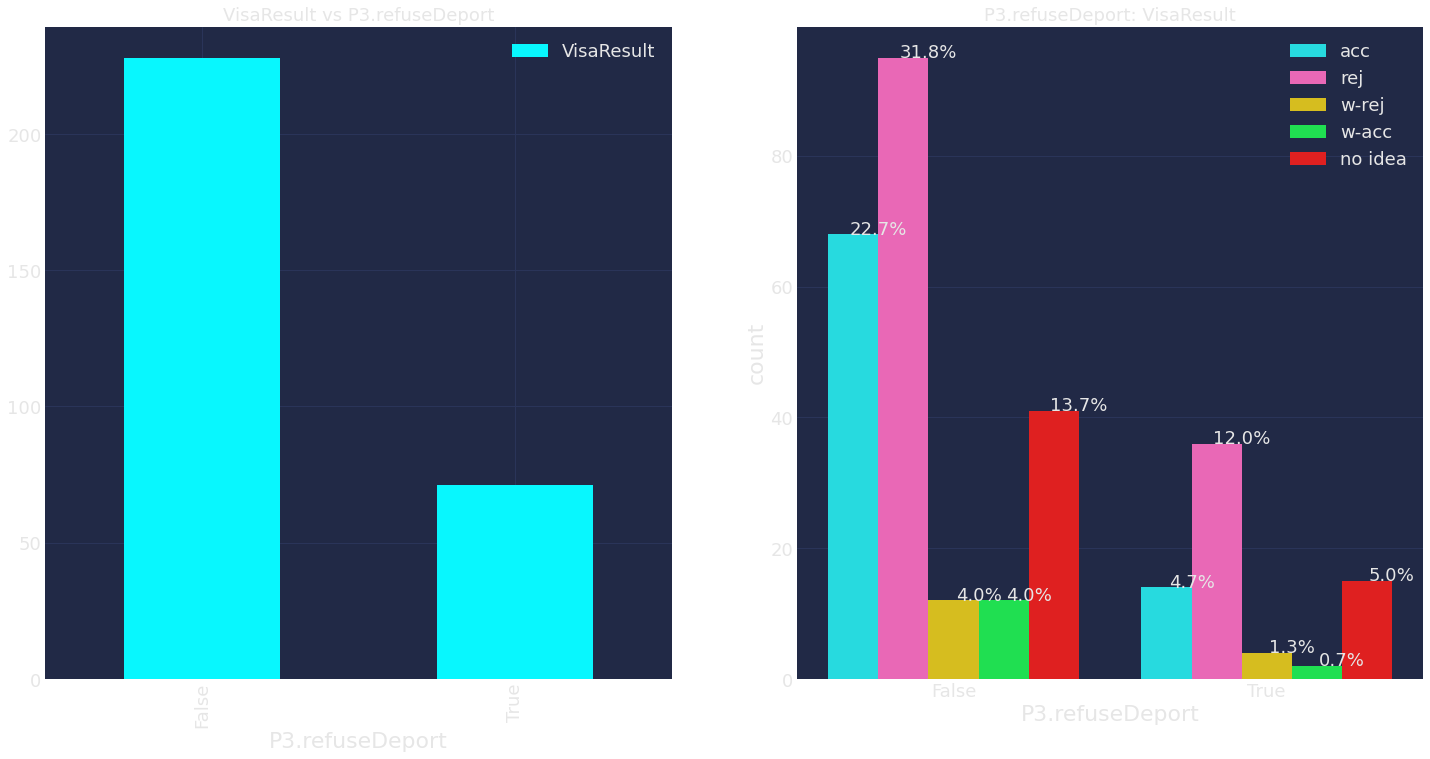

In [148]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
for p in ax[1].patches:  # https://stackoverflow.com/a/63479557/18971263
    percentage = '{:.1f}%'.format(100 * p.get_height()/float(len(data)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax[1].annotate(percentage, (x, y), ha='center')
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()


Of course, those who have previous rejected cases are more likely to get rejected again.

### P3.BGI2.PrevApply -> categorical

In [149]:
output_name = 'VisaResult'
feature_name = 'P3.BGI2.PrevApply'
data.groupby([feature_name, output_name])[output_name].count()

P3.BGI2.PrevApply  VisaResult
False              acc            44
                   no idea        41
                   rej           107
                   w-acc          14
                   w-rej          14
True               acc            38
                   no idea        15
                   rej            24
                   w-rej           2
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


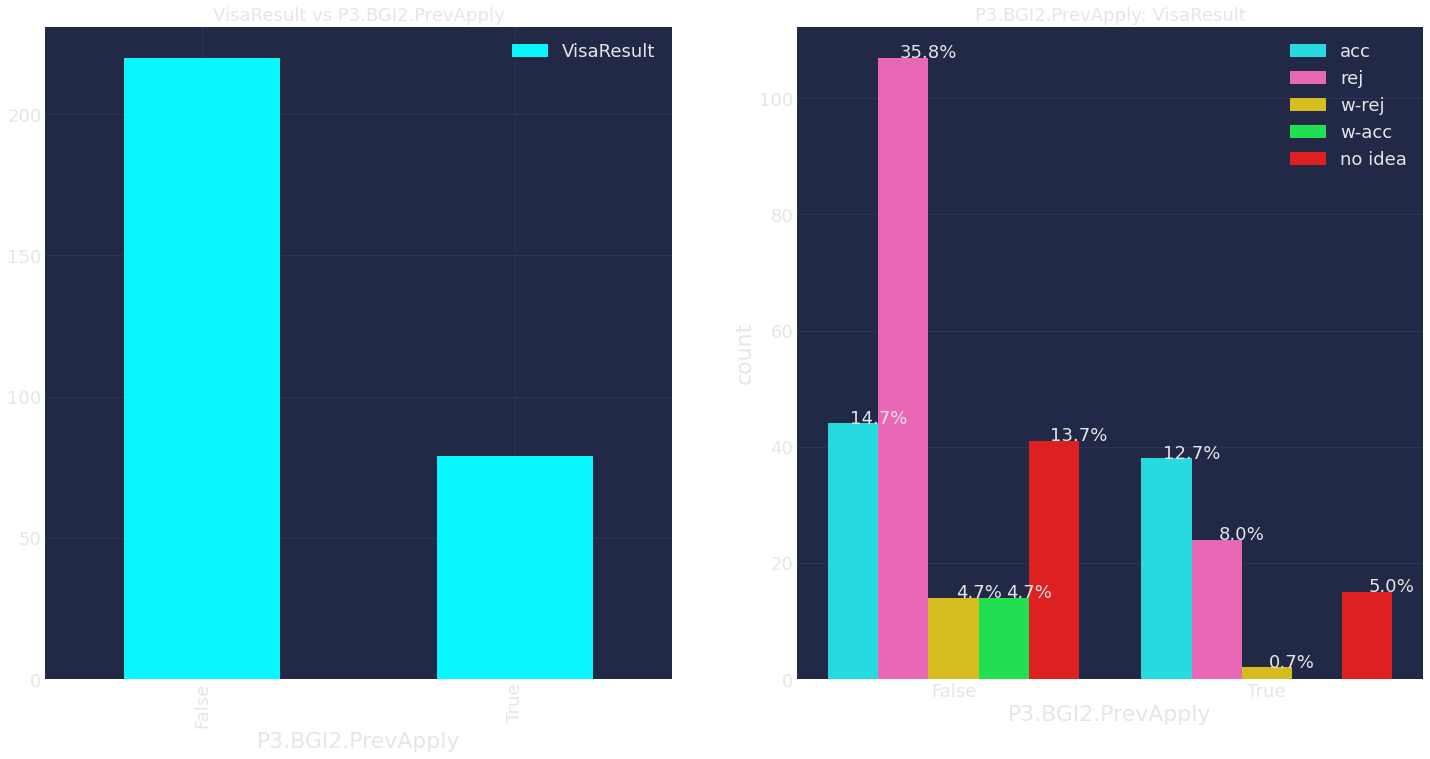

In [150]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
for p in ax[1].patches:  # https://stackoverflow.com/a/63479557/18971263
    percentage = '{:.1f}%'.format(100 * p.get_height()/float(len(data)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax[1].annotate(percentage, (x, y), ha='center')
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()


Well, it sounds obvious that if someone got the visa before, it is more likely to get the visa once again and vice versa. So, let's compare with `'P3.refuseDeport'` to see the relation between previous applies that succeeded or failed.

In [151]:
feature_name = 'P3.BGI2.PrevApply', 'P3.refuseDeport'

ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) *100
ct

VisaResult                               acc        rej         All
P3.BGI2.PrevApply P3.refuseDeport                                  
False             False            17.840376  42.723005   60.563380
                  True              2.816901   7.511737   10.328638
True              False            14.084507   1.877934   15.962441
                  True              3.755869   9.389671   13.145540
All                                38.497653  61.502347  100.000000

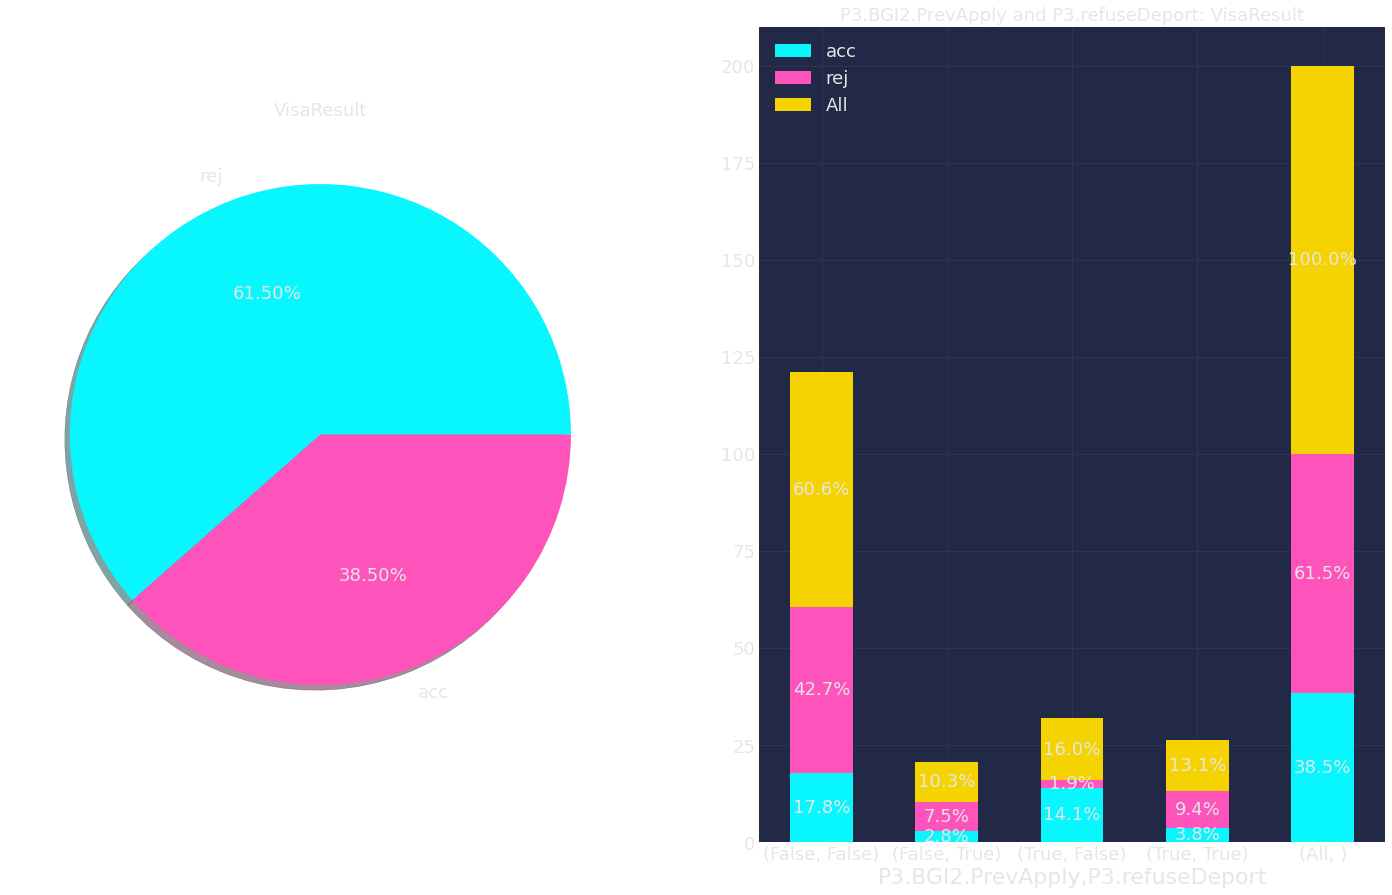

In [152]:
f, ax = plt.subplots(1, 2, figsize=(22, 15))
data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name].value_counts().plot.pie(
    autopct='%1.2f%%', ax=ax[0], shadow=True)
ax[0].set_title('VisaResult')
ax[0].set_ylabel('')

ct.plot(kind='bar', stacked=True, rot=0, ax=ax[1])
ax[1].set_title('{} and {}: {}'.format(
    feature_name[0], feature_name[1], output_name))
ax[1].legend(loc='upper left')
for c in ax[1].containers:
    ax[1].bar_label(c, label_type='center', fmt='%1.1f%%')
plt.show()


First of all, we can see that %38.7 of applicants got visa. Now, let's see how many of them got it because of their previous apply.

Insights:
1. As we can see from the 3rd column, around %14.5 of applicant got visa because they had applied previously and got accepted. 
2. Interestingly, around %6.5(=2.8+3.7) of applicant got visa, even though they have been previously rejected.
3. Other %17.8 got visa without any prior record.
4. Having visa rejection (2nd column) reduces the chance of acceptance by at least 2 times!

### P3.PWrapper.criminalRec -> categorical

In [153]:
output_name = 'VisaResult'
feature_name = 'P3.PWrapper.criminalRec'
data.groupby([feature_name, output_name])[output_name].count()

P3.PWrapper.criminalRec  VisaResult
False                    acc            82
                         no idea        56
                         rej           131
                         w-acc          14
                         w-rej          16
Name: VisaResult, dtype: int64

In [154]:
# drop useless
feature_name = 'P3.PWrapper.criminalRec'
data.drop(feature_name, axis=1, inplace=True)

### P3.PWrapper.Military.Choice -> categorical

In [155]:
output_name = 'VisaResult'
feature_name = 'P3.PWrapper.Military.Choice'
data.groupby([feature_name, output_name])[output_name].count()

P3.PWrapper.Military.Choice  VisaResult
False                        acc            80
                             no idea        54
                             rej           128
                             w-acc          14
                             w-rej          16
True                         acc             2
                             no idea         2
                             rej             3
Name: VisaResult, dtype: int64

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


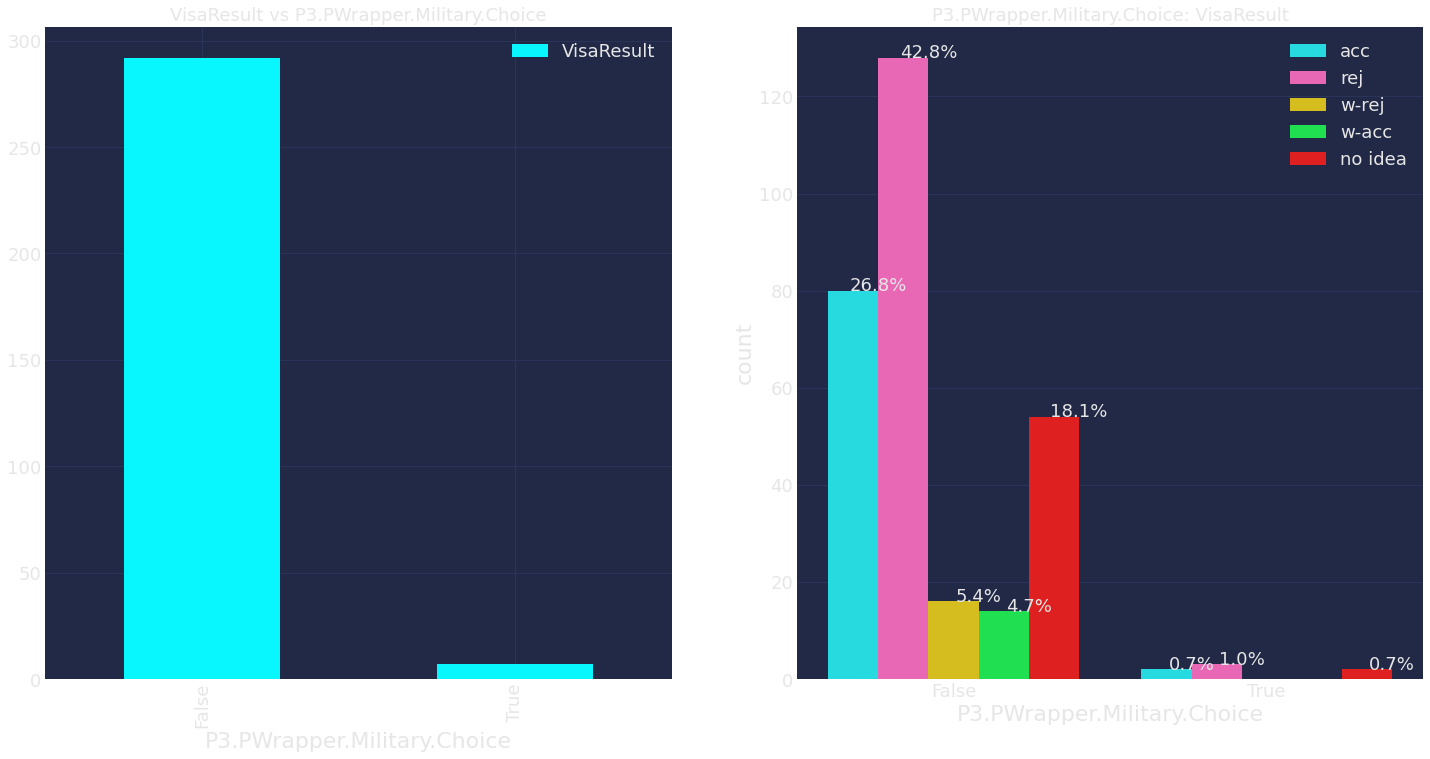

In [156]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
for p in ax[1].patches:  # https://stackoverflow.com/a/63479557/18971263
    percentage = '{:.1f}%'.format(100 * p.get_height()/float(len(data)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax[1].annotate(percentage, (x, y), ha='center')
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()


It's nothing to consider. If all was rejected, we could say it is a warning, but apparently has no effect. Especially, many have done compulsory service. Hence, for now we drop it.

In [157]:
# drop useless
feature_name = 'P3.PWrapper.Military.Choice'
data.drop(feature_name, axis=1, inplace=True)

### P3.PWrapper.politicViol -> categorical

In [158]:
output_name = 'VisaResult'
feature_name = 'P3.PWrapper.politicViol'
data.groupby([feature_name, output_name])[output_name].count()

P3.PWrapper.politicViol  VisaResult
False                    acc            82
                         no idea        56
                         rej           131
                         w-acc          14
                         w-rej          16
Name: VisaResult, dtype: int64

So ... Yea... everybody lied that they have not seen any mistreatment! KEKSociety.

In [159]:
# drop useless
feature_name = 'P3.PWrapper.politicViol'
data.drop(feature_name, axis=1, inplace=True)

### P3.PWrapper.witnessIllTreat -> categorical

In [160]:
output_name = 'VisaResult'
feature_name = 'P3.PWrapper.witnessIllTreat'
data.groupby([feature_name, output_name])[output_name].count()

P3.PWrapper.witnessIllTreat  VisaResult
False                        acc            82
                             no idea        56
                             rej           131
                             w-acc          14
                             w-rej          16
Name: VisaResult, dtype: int64

In [161]:
# drop useless
feature_name = 'P3.PWrapper.witnessIllTreat'
data.drop(feature_name, axis=1, inplace=True)

### P1.PD.CurrCOR.Row2.Period -> continuous

This part is a little different, since most of the people are single-national citizens (in our domain at least), then their `'CurrCOR'` and `'DOBYear.Period'` are the same value.
So we prefer to compare these to together as a joint variable. 

In [165]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CurrCOR.Row2.Period', 'P1.PD.DOBYear.Period'

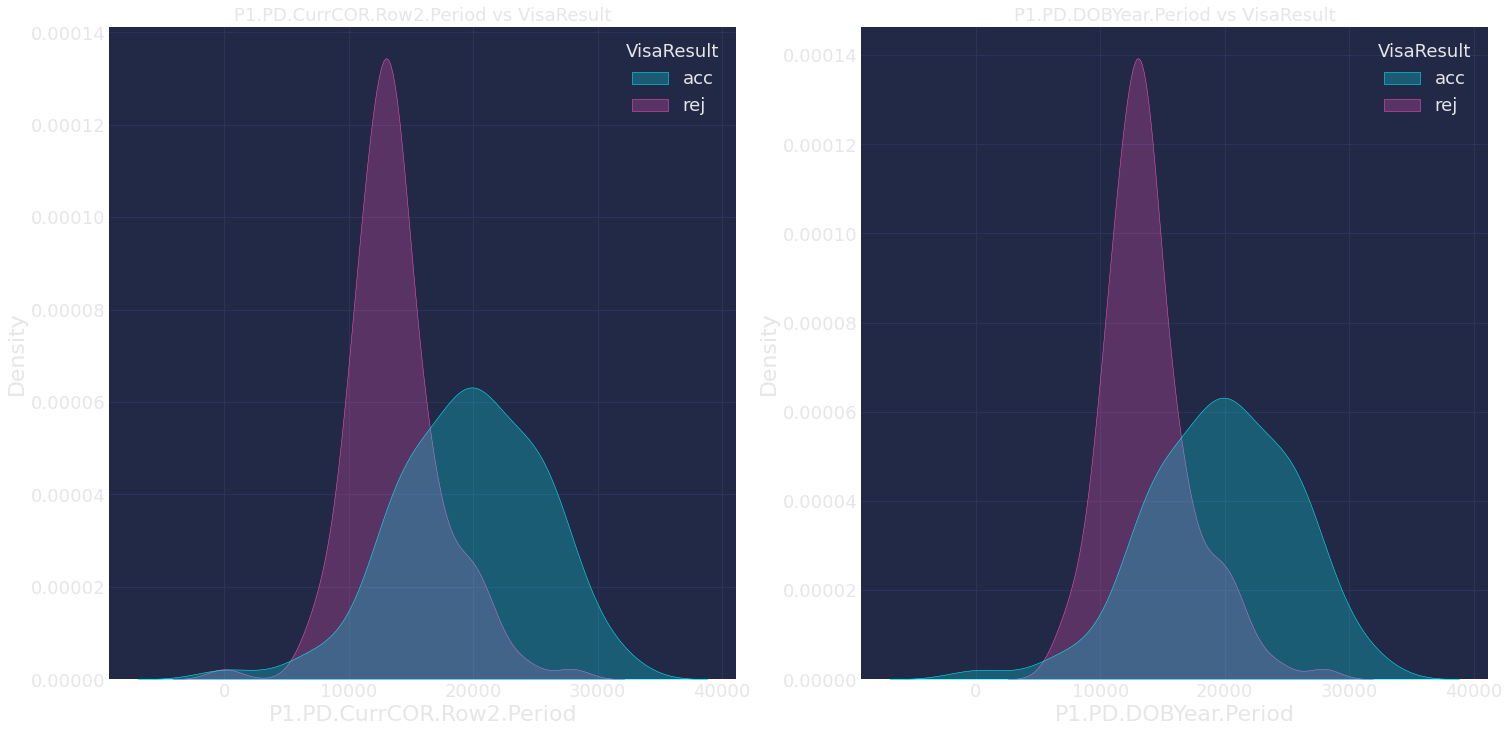

In [166]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.kdeplot(x=feature_name[0], hue=output_name, common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax[0])
ax[0].set_title('{} vs {}'.format(feature_name[0], output_name))
sns.kdeplot(x=feature_name[1], hue=output_name, common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[1], output_name))
plt.show()

As we can see, both data has the same distribution except a small proportion (around 0) which can be considered as anomaly. Hence, I think dropping this `'CurrCOR'` is a rational choice. But to make sure, we plot these these two variables against each other.

In [169]:
# sns.displot(
#     data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], x=feature_name[0], y=feature_name[1], hue=output_name,
#     kind="kde", rug=True, height=12)
# plt.title('{} vs {}'.format(feature_name[1], output_name))
# plt.show()

In [170]:
# drop useless
feature_name = 'P1.PD.CurrCOR.Row2.Period'
data.drop(feature_name, axis=1, inplace=True)

### 'P1.PD.DOBYear.Period' -> continuous

In [171]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period'

In [172]:
# convert to years but continuous
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

In [173]:
data[data[feature_name]<=25].groupby([feature_name, output_name])[output_name].count()

P1.PD.DOBYear.Period  VisaResult
0.679452              acc           1
17.895890             rej           1
18.621918             acc           1
19.202740             acc           1
20.076712             rej           1
20.482192             rej           1
21.076712             rej           1
22.131507             no idea       1
22.356164             rej           1
22.534247             rej           1
23.926027             no idea       1
Name: VisaResult, dtype: int64

Let's get rid of that kid first. But I decided to keep others (e.g. 17, 18, ... years old kids) and the reason is that they have been proportionately rejected. So, if they wanted to go alone, or with family, there is something that caused them to get rejected. So, let's keep em.

In [174]:
data.drop(data[data[feature_name]<=1].index, inplace=True)
data[data[feature_name]<=1][feature_name]

Series([], Name: P1.PD.DOBYear.Period, dtype: float64)

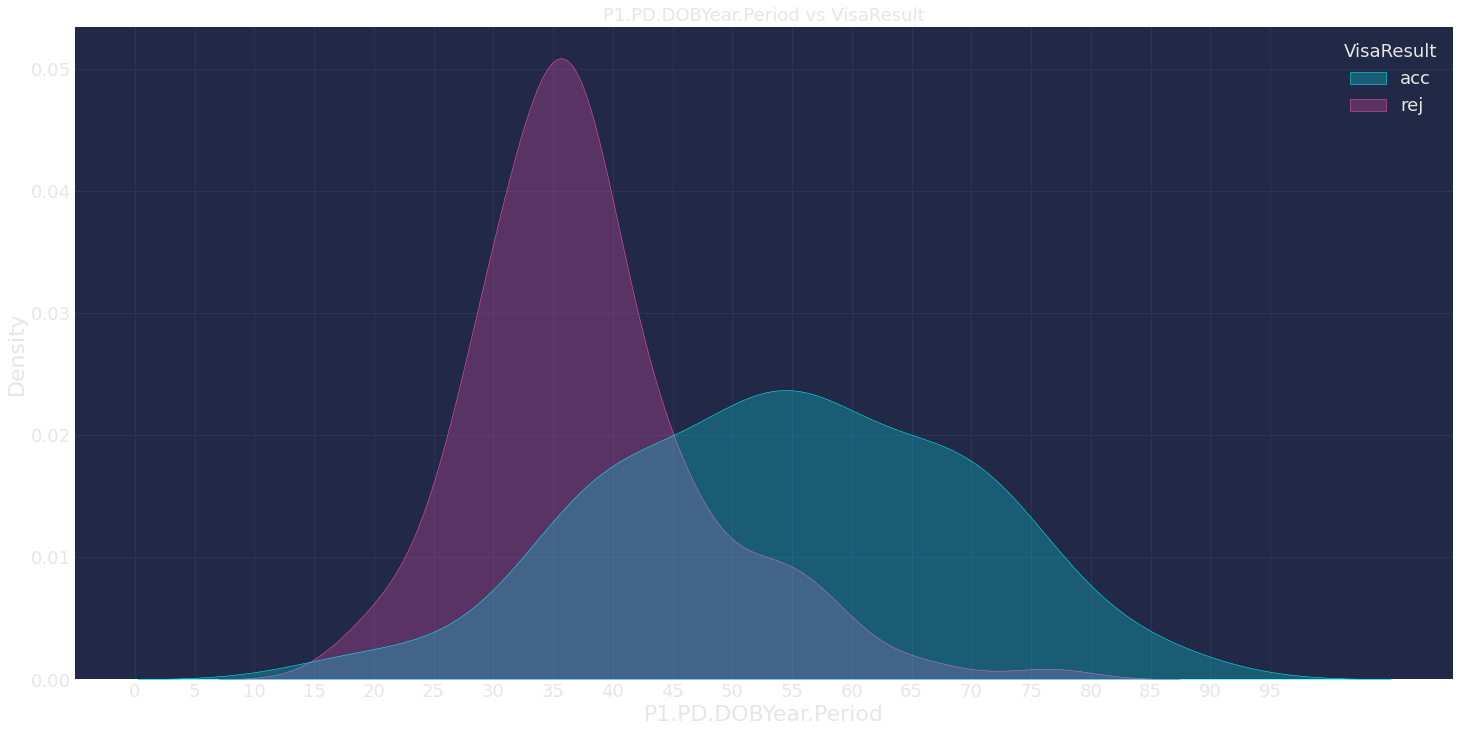

In [175]:
f, ax = plt.subplots(1, 1, figsize=(22, 12))
sns.kdeplot(x=feature_name, hue=output_name, common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax)
ax.set_title('{} vs {}'.format(feature_name, output_name))
ax.set_xticks(range(0, 100, 5))
plt.show()

### 'P1.PD.DOBYear.Period' and a second feature

#### 'P1.PD.DOBYear.Period' and 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [176]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit', 'P1.PD.Sex.Sex'

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


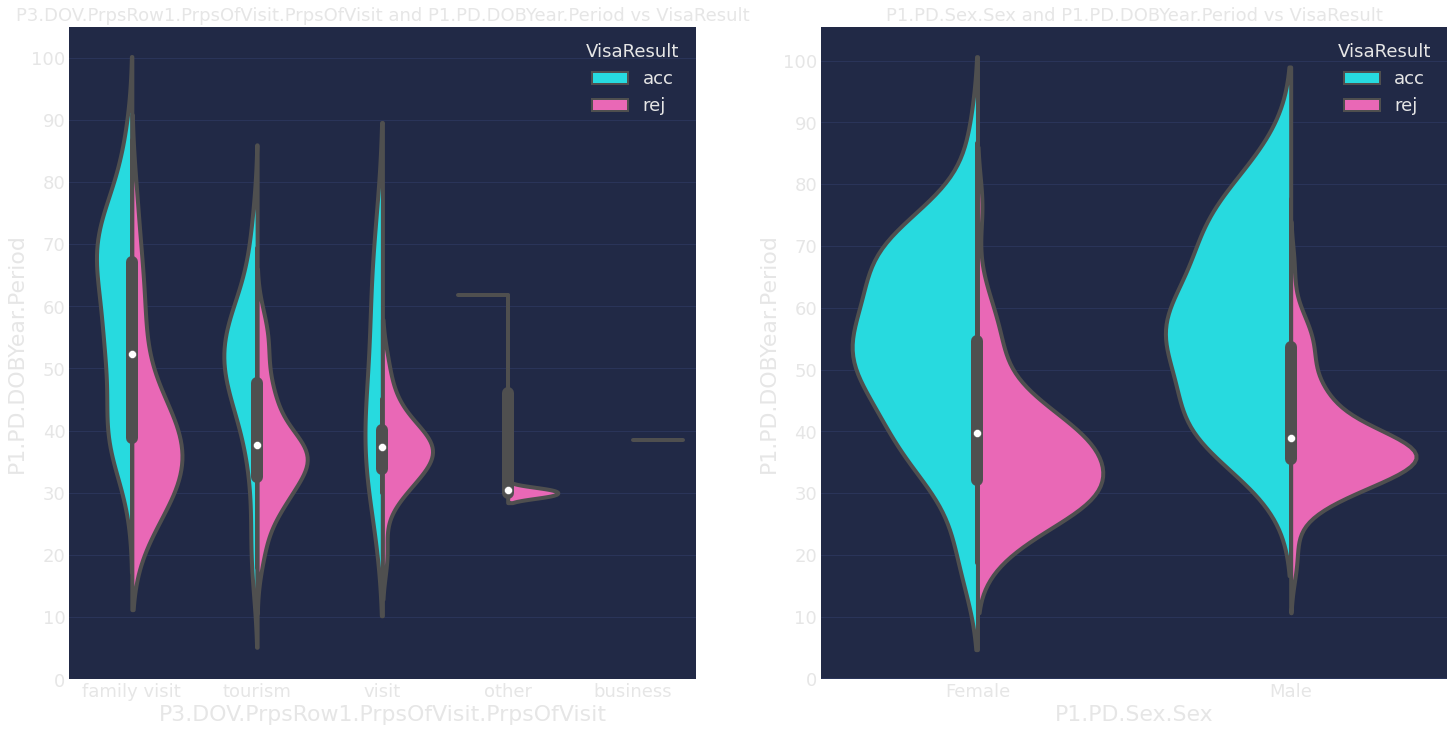

In [177]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(feature_name[1], feature_name[0], scale='area', 
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot(feature_name[2], feature_name[0], scale='width', 
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[1])
ax[1].set_title('{} and {} vs {}'.format(feature_name[2], feature_name[0], output_name))
ax[1].set_yticks(range(0, 110, 10))
plt.show()


Insights:
1. The lower the age, the lower the likelihood
2. 'family visit' dominates the age and increases the likelihood considerably
3. There is not much difference in 'tourism' and 'visit' and 'age' is the the important factor again
4. The peak of rejection for 'Male' is around 40 while for 'Female' is around 30 and the reason is that usually in families, men have higher age than women.


#### 'P1.PD.DOBYear.Period' and 'P3.DOV.PrpsRow1.Funds.Funds' -> continuous

In [178]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period', 'P3.DOV.PrpsRow1.Funds.Funds'

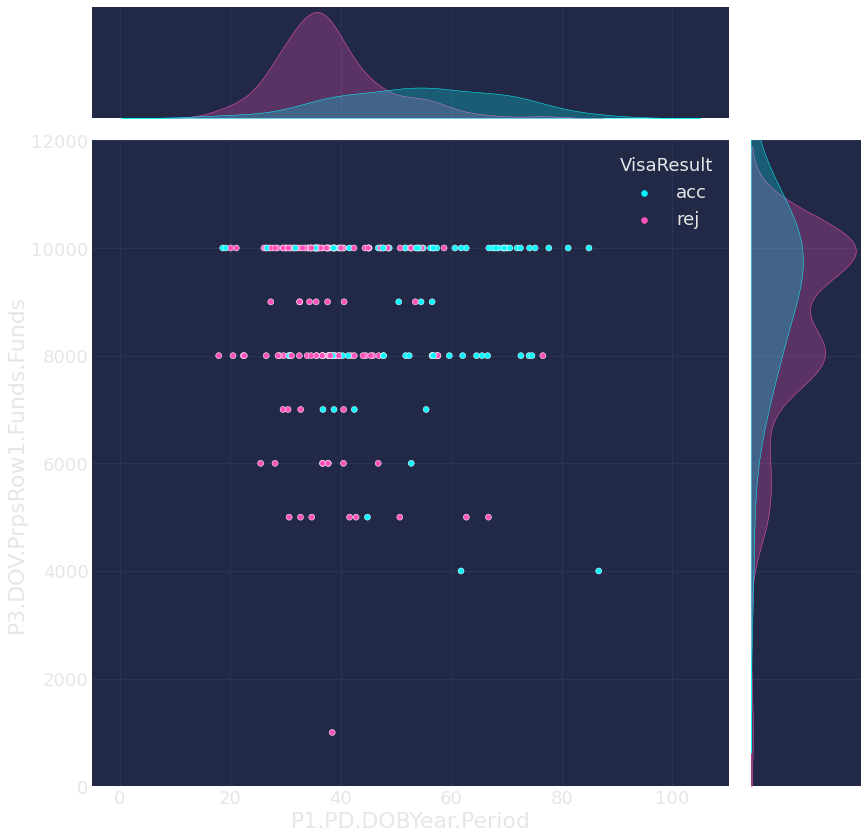

In [179]:
sns.jointplot(
    data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], x=feature_name[0], y=feature_name[1], hue=output_name, height=12)
plt.ylim(0, 12e3)
# plt.title('{} and {} vs {}'.format(feature_name[0], feature_name[1], output_name))
plt.show()

Since lower age decreases the likelihood of acceptance considerably, having larger funds is compensating.

#### 'P1.PD.DOBYear.Period' and 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [180]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period', 'P1.MS.SecA.MS'

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


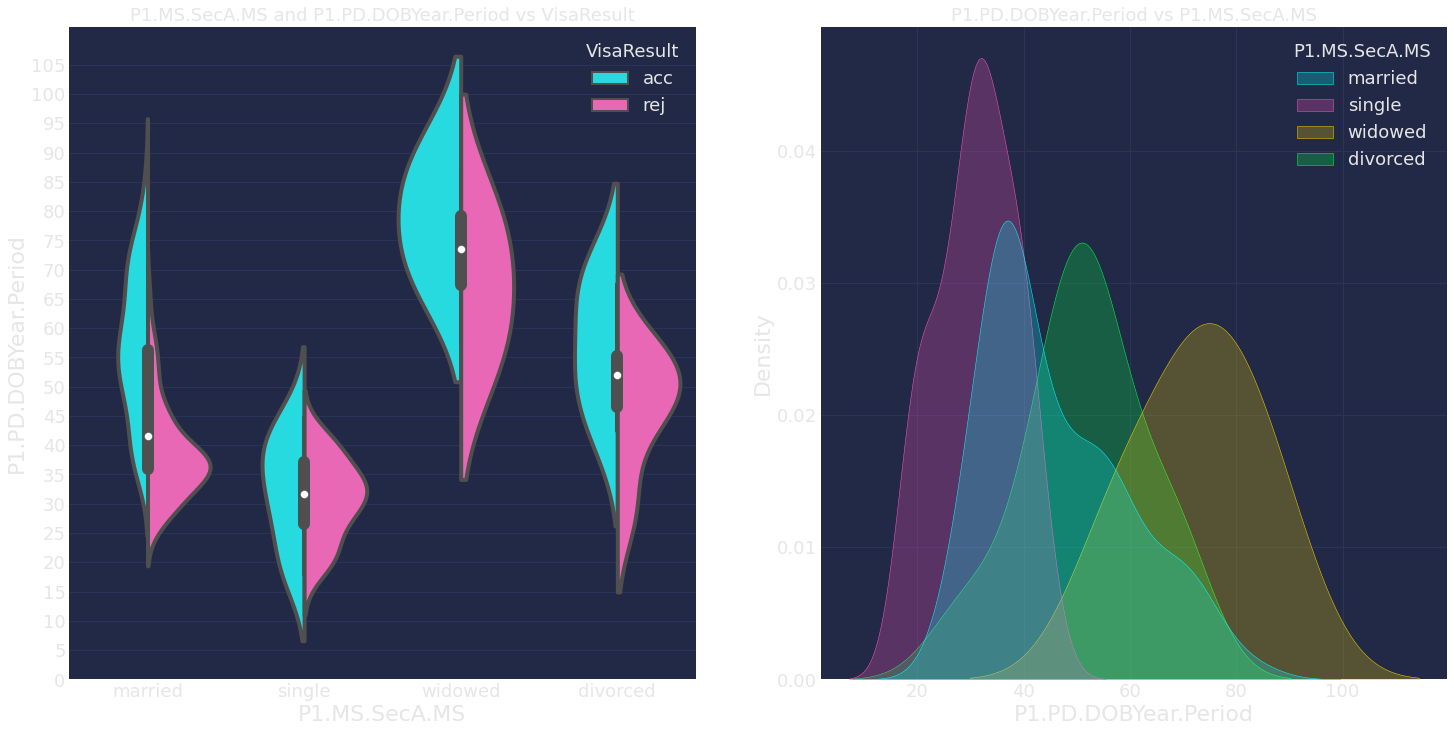

In [181]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(feature_name[1], feature_name[0], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 110, 5))
sns.kdeplot(x=feature_name[0], hue=feature_name[1], common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[0], feature_name[1]))
# ax[1, 1].set_xticks(range(0, 100, 5))
plt.show()


It seems that 'marital status' has been encoded in 'age' or wise versa.

For instance:
1. Single people's acceptance mean is way lower age than other groups. This is counter intuitive, because most of these young and 'single' people are with their family probably, so their parents are the actual applicants. This can be confirmed by looking at the trail of 'single' where it expands to lower ages.
2. 'divorced' and 'married' people's age seems irrelevant. Although, we see that peak of rejection and acceptance for 'divorced' people are higher and this is obvious since usually, 'divorced' people have higher average age.
3. 'widowed' case has similar status as the latter statement in 2.

### 'P1.MS.SecA.DateOfMarr.Period' -> continuous

In [182]:
# convert to years but continuous
feature_name = 'P1.MS.SecA.DateOfMarr.Period'
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

In [183]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.DateOfMarr.Period', 'P1.PD.Sex.Sex'

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


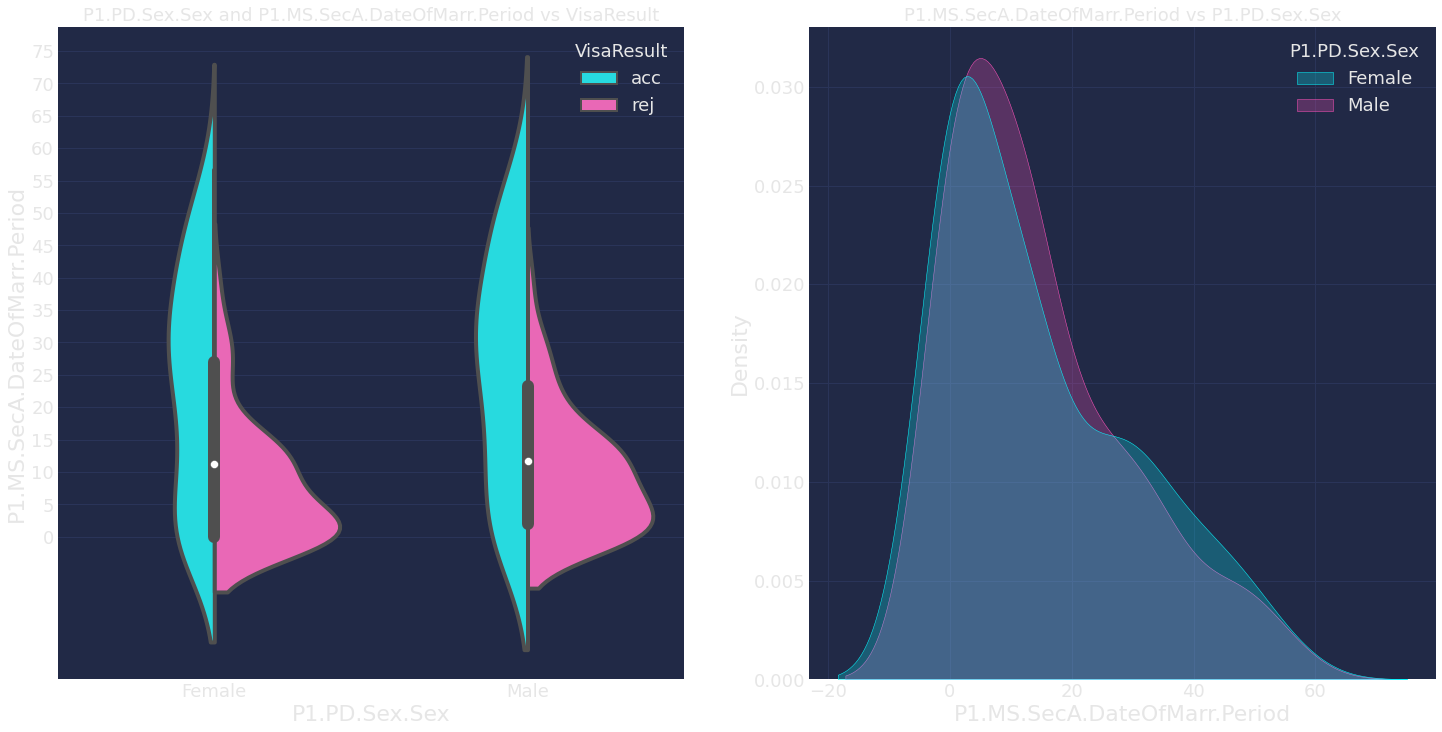

In [184]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(feature_name[1], feature_name[0], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 80, 5))
sns.kdeplot(x=feature_name[0], hue=feature_name[1], common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[0], feature_name[1]))
plt.show()


Seems like there is no insight in relation of gender to marriage period.

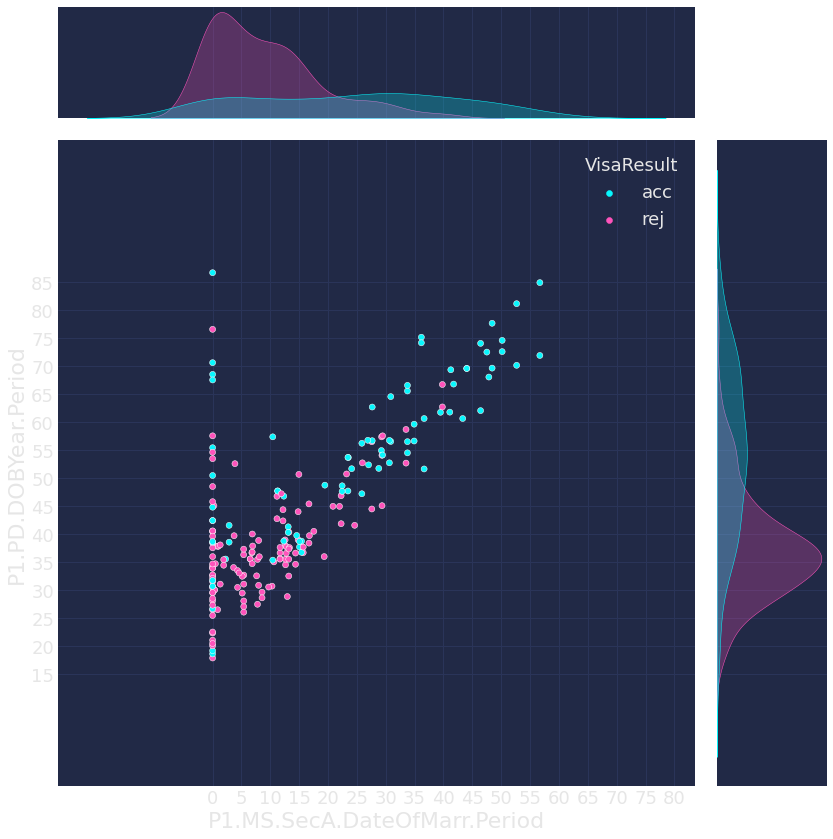

In [185]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.DateOfMarr.Period', 'P1.PD.DOBYear.Period'
g= sns.jointplot(
    data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], x=feature_name[0], y=feature_name[1], hue=output_name, height=12)
g.ax_joint.set_xticks(range(0, 81, 5))
g.ax_joint.set_yticks(range(15, 90, 5))
plt.show()

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


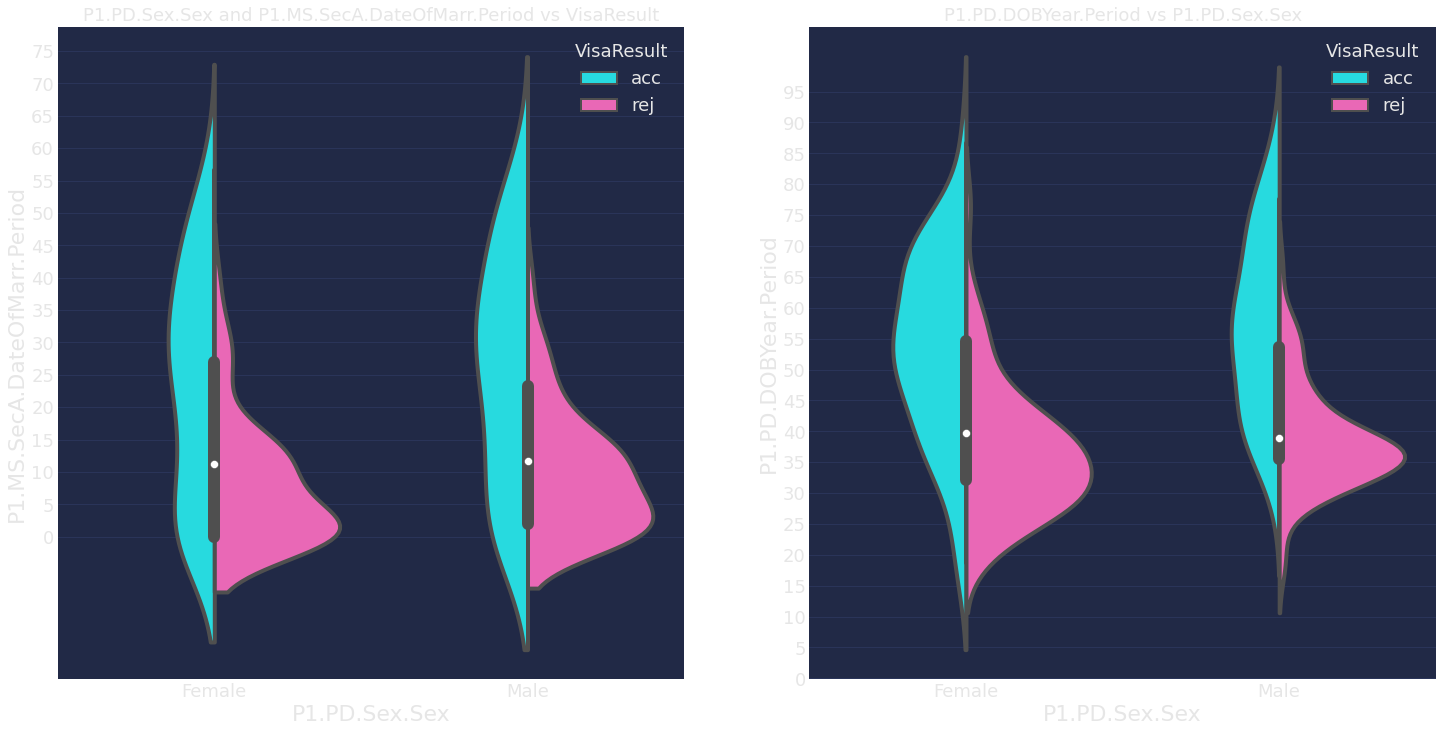

In [186]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.DateOfMarr.Period', 'P1.PD.Sex.Sex', 'P1.PD.DOBYear.Period', 

f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(feature_name[1], feature_name[0],
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 80, 5))
sns.violinplot(feature_name[1], feature_name[2],
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[2], feature_name[1]))
ax[1].set_yticks(range(0, 100, 5))
plt.show()


Even though it seems that a lot of people with short to medium marriages (<=10) when they are in their early 30s or late 20s have been rejected (previous scatter graph), here, we can see that having marriage even for a short period increases the likelihood considerably (look at the bumps on the figure on the left around Yaxis=0 and smooth very low density on the figure on the right.)

TODO: see issue #15. Seems that such a thing would improve.

### 'P2.MS.SecA.PrevSpouseDOB.DOBYear.Period' and 'P2.MS.SecA.Period' -> continuous

In [187]:
# convert to years but continuous
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.PrevSpouseDOB.DOBYear.Period', 'P2.MS.SecA.Period'
data[feature_name[0]] = data[feature_name[0]].apply(lambda x: x/365.)
data[feature_name[1]] = data[feature_name[1]].apply(lambda x: x/365.)

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


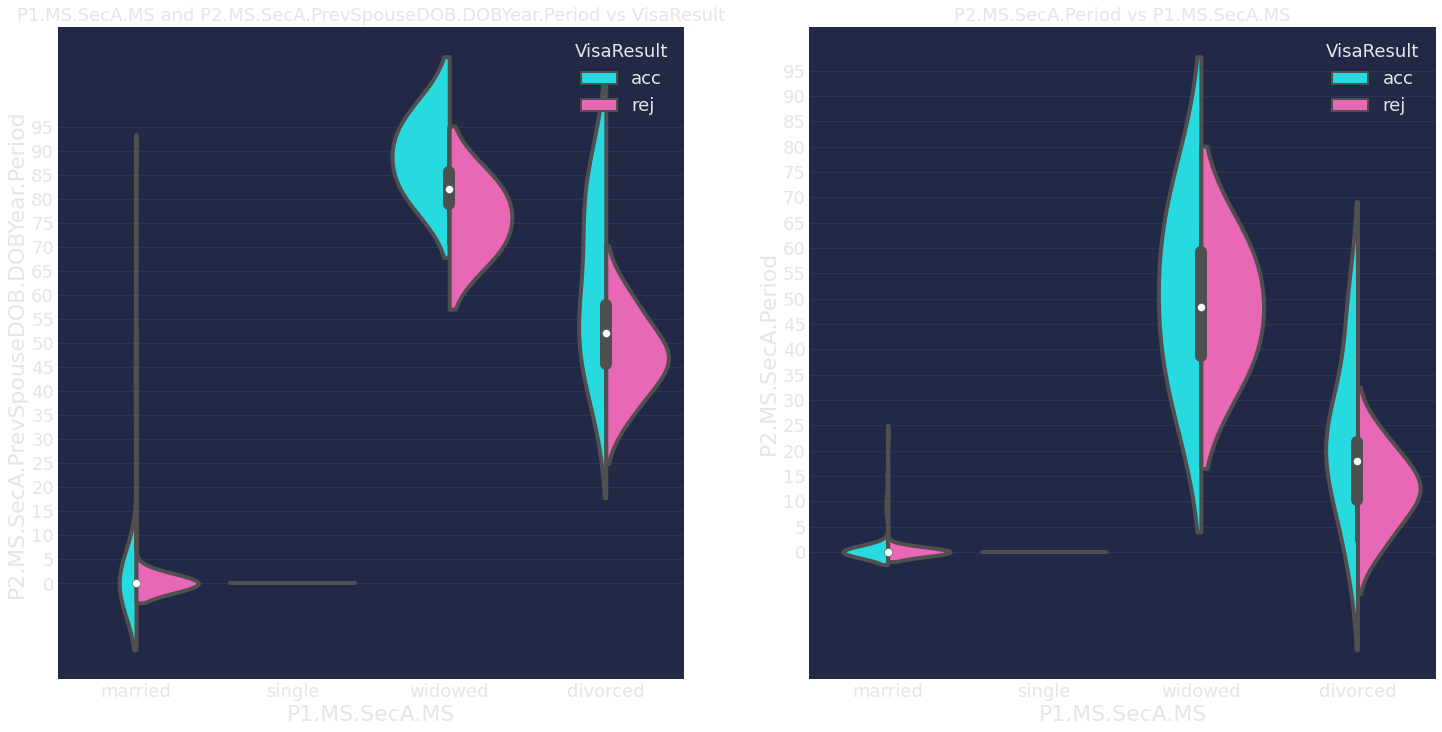

In [188]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.PrevSpouseDOB.DOBYear.Period', 'P1.MS.SecA.MS', 'P2.MS.SecA.Period'

f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(feature_name[1], feature_name[0],
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 100, 5))
sns.violinplot(feature_name[1], feature_name[2],
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[2], feature_name[1]))
ax[1].set_yticks(range(0, 100, 5))
plt.show()


It is hard to extract any insights from it since all range of age exist for all categories (except single/married of course), so I leave it there until further investigation.

TODO: maybe delete? no idea how useful it is 
1. Having previous marriage's period seems to contain all information we need about previous marriage, hence, the age of previous spouse does not provide any useful information.

In [189]:
# drop useless
feature_name = 'P2.MS.SecA.PrevSpouseDOB.DOBYear.Period'
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Psprt.ExpiryDate.Remaining -> continuous

In [190]:
# convert to years but continuous
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Psprt.ExpiryDate.Remaining'
data[feature_name] = data[feature_name].apply(lambda x: x/30.)

In [191]:
feature_name = 'P2.MS.SecA.Psprt.ExpiryDate.Remaining'
print(data[data[feature_name] < 5.].__len__())

2


For some reason, we have to samples that have negative expiration date. For conversion, we can use `.abs` to mirror them or use statistical methods to fill, e.g. `mode`.

In [192]:
data.loc[data[feature_name] < 5., feature_name] = data[data[feature_name] < 5.][feature_name].apply(lambda x: np.abs(x))
print(data[data[feature_name] < 5.].__len__())

0


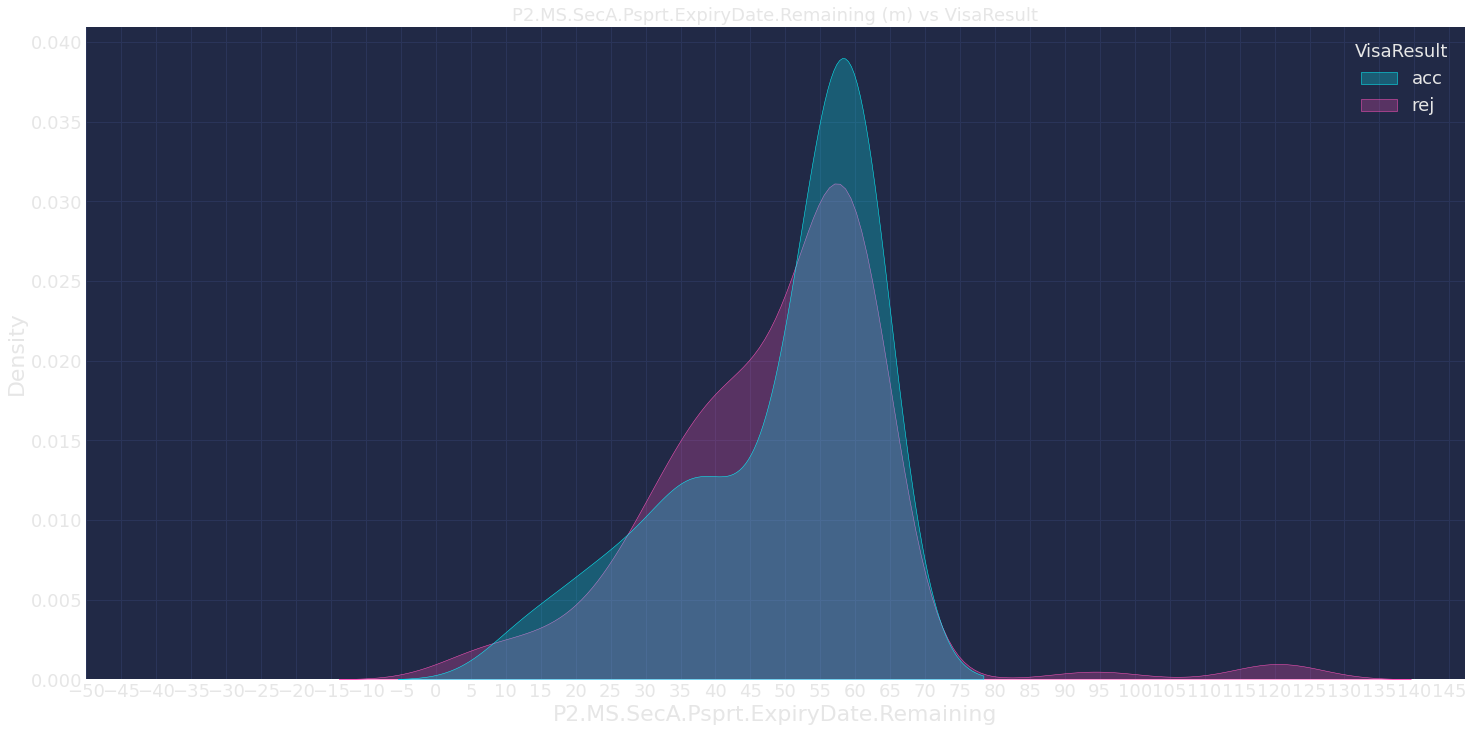

In [193]:
feature_name = 'P2.MS.SecA.Psprt.ExpiryDate.Remaining'
f, ax = plt.subplots(1, 1, figsize=(22, 12))
sns.kdeplot(x=feature_name, hue=output_name, common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax)
ax.set_xticks(range(-50, 150, 5))
ax.set_title('{} (m) vs {}'.format(feature_name, output_name))
plt.show()


There are three points of interest here, one around 5-10 and the other around 60 on x axis.
1. 5-10: It seems that not having long enough expiration date on passport suggests that the applicant is more likely to get rejected.
2. 60: 60 month or 5 years are the expiration period for fresh Iranian passports and it might mean that they are children of a family and their parent's features are carrying them.

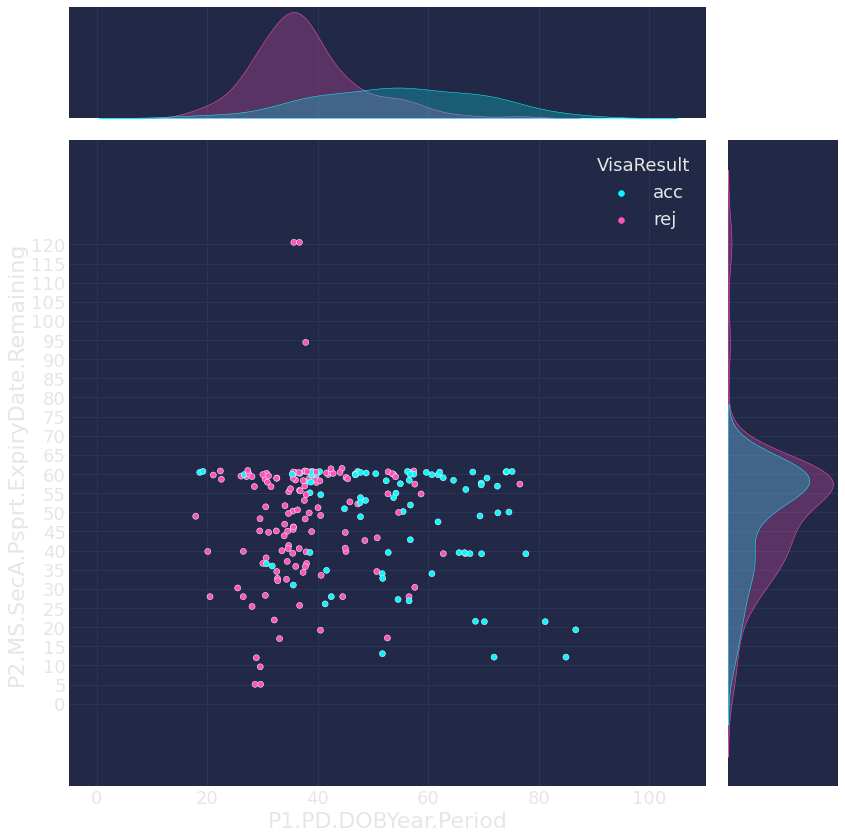

In [194]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period', 'P2.MS.SecA.Psprt.ExpiryDate.Remaining'
g = sns.jointplot(
    data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], x=feature_name[0], y=feature_name[1], hue=output_name, height=12)
# g.ax_joint.set_xticks(range(0, 81, 5))
g.ax_joint.set_yticks(range(0, 125, 5))
plt.show()

### P3.DOV.PrpsRow1.HLS.Period -> continuous

#### P3.DOV.PrpsRow1.HLS.Period and 'P3.DOV.PrpsRow1.Funds.Funds'

In [213]:
# convert to years but continuous
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.HLS.Period', 'P3.DOV.PrpsRow1.Funds.Funds'

In [199]:
data[data[feature_name[1]] > 10000]

,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row3.Country,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Country.Country,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult,P1.PD.PrevCOR.Row.Count
110,False,Male,IRAN,1.0,1.429856,1.429856,True,TURKEY,6.0,married,False,family visit,30000.0,f1,ukn,False,1.000000,1.107154,1.107154,1.107154,False,False,False,60.649315,0.0,0.0,NaN,36.643836,0.0,33.966667,31.0,0.0,13149.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,IRAN,PERSIAN-PICTURE CARPET WEAVER,True,IRAN,HOUSEWIFE,False,5.0,IRAN,CHEF RETIRED,False,5.0,5.0,DAUGHTER,IRAN,ARCHITECT,False,6.0,SON,IRAN,STUDENT,False,6.0,SON,IRAN,STUDENT,True,9.0,OTHER,IRAN,OTHER,False,5.0,SISTER,IRAN,HOUSEWIFE,False,5.0,BROTHER,IRAN,CHEF,False,5.0,SISTER,IRAN,HOUSEWIFE,False,5.0,BROTHER,IRAN,CHEF,False,5.0,SISTER,IRAN,HOUSEWIFE,False,5.0,BROTHER,IRAN,CHEF,False,9.0,OTHER,IRAN,OTHER,False,18909.0,27158.0,29831.0,12957.0,12586.0,2683.0,9408.666667,22426.0,20547.0,18876.0,16686.0,15095.0,13889.0,17919.833333,acc,0
220,False,Female,IRAN,1.0,1.429856,1.429856,False,TURKEY,3.0,married,False,family visit,20000.0,f2,f2,True,3.177804,1.107154,1.107154,1.107154,False,True,True,37.038356,0.0

we have two cases where have 20K and 30K funds, hence, for visualization purposes, I have excluded them.

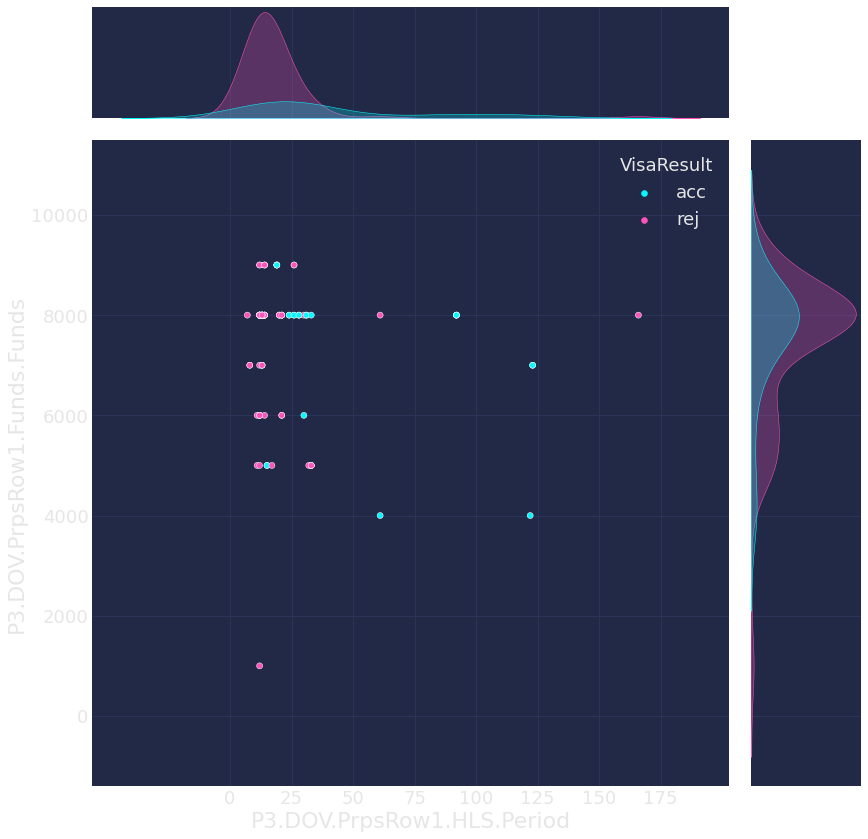

In [214]:
g = sns.jointplot(
    data=data[((data[output_name] == 'acc') | (data[output_name] == 'rej')) & (data[feature_name[1]] < 10000)],
    x=feature_name[0], y=feature_name[1], hue=output_name, height=12)
g.ax_joint.set_xticks(range(0, 200, 25))
plt.show()

#### P3.DOV.PrpsRow1.HLS.Period and 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [218]:
# convert to years but continuous
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.HLS.Period', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nik/anaconda3/envs/py39l/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


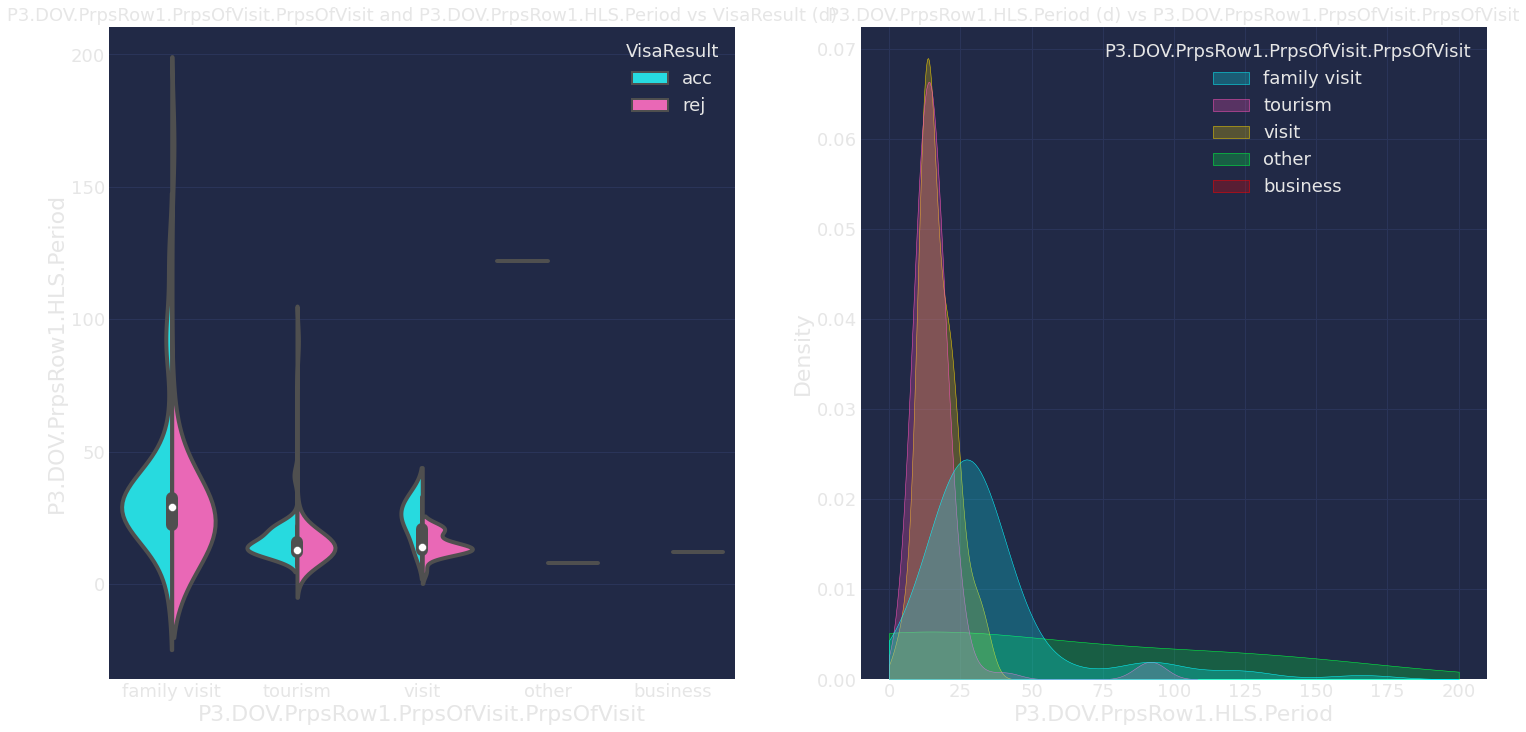

In [219]:
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(feature_name[1], feature_name[0], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {} (d)'.format(feature_name[1], feature_name[0], output_name))
# ax[0].set_yticks(range(0, 110, 5))
sns.kdeplot(x=feature_name[0], hue=feature_name[1], common_norm=False, clip=(0, 200),
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax[1])
ax[1].set_title('{} (d) vs {}'.format(feature_name[0], feature_name[1]))
# ax[1, 1].set_xticks(range(0, 100, 5))
plt.show()


In [217]:
data.head()

,P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator,P1.PD.Sex.Sex,P1.PD.CurrCOR.Row2.Country,P1.PD.CurrCOR.Row2.Status,P1.PD.PrevCOR.Row2.Country,P1.PD.PrevCOR.Row3.Country,P1.PD.SameAsCORIndicator,P1.PD.CWA.Row2.Country,P1.PD.CWA.Row2.Status,P1.MS.SecA.MS,P2.MS.SecA.PrevMarrIndicator,P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit,P3.DOV.PrpsRow1.Funds.Funds,P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe,P3.cntcts_Row2.Relationship.RelationshipToMe,P3.Edu.EduIndicator,P3.Edu.Edu_Row1.Country.Country,P3.Occ.OccRow1.Country.Country,P3.Occ.OccRow2.Country.Country,P3.Occ.OccRow3.Country.Country,P3.noAuthStay,P3.refuseDeport,P3.BGI2.PrevApply,P1.PD.DOBYear.Period,P1.PD.PrevCOR.Row2.Period,P1.PD.PrevCOR.Row3.Period,P1.PD.CWA.Row2.Period,P1.MS.SecA.DateOfMarr.Period,P2.MS.SecA.Period,P2.MS.SecA.Psprt.ExpiryDate.Remaining,P3.DOV.PrpsRow1.HLS.Period,P3.Edu.Edu_Row1.Period,P3.Occ.OccRow1.Period,P3.Occ.OccRow2.Period,P3.Occ.OccRow3.Period,p1.Subform1.Visitor,p1.Subform1.Worker,p1.Subform1.Student,p1.Subform1.Other,p1.SecA.App.ChdMStatus,p1.SecA.Sps.SpsCOB,p1.SecA.Sps.SpsOcc,p1.SecA.Sps.SpsAccomp,p1.SecA.Mo.MoCOB,p1.SecA.Mo.MoOcc,p1.SecA.Mo.MoAccomp,p1.SecA.Mo.ChdMStatus,p1.SecA.Fa.FaCOB,p1.SecA.Fa.FaOcc,p1.SecA.Fa.FaAccomp,p1.SecA.Fa.ChdMStatus,p1.SecB.Chd.[0].ChdMStatus,p1.SecB.Chd.[0].ChdRel,p1.SecB.Chd.[0].ChdCOB,p1.SecB.Chd.[0].ChdOcc,p1.SecB.Chd.[0].ChdAccomp,p1.SecB.Chd.[1].ChdMStatus,p1.SecB.Chd.[1].ChdRel,p1.SecB.Chd.[1].ChdCOB,p1.SecB.Chd.[1].ChdOcc,p1.SecB.Chd.[1].ChdAccomp,p1.SecB.Chd.[2].ChdMStatus,p1.SecB.Chd.[2].ChdRel,p1.SecB.Chd.[2].ChdCOB,p1.SecB.Chd.[2].ChdOcc,p1.SecB.Chd.[2].ChdAccomp,p1.SecB.Chd.[3].ChdMStatus,p1.SecB.Chd.[3].ChdRel,p1.SecB.Chd.[3].ChdCOB,p1.SecB.Chd.[3].ChdOcc,p1.SecB.Chd.[3].ChdAccomp,p1.SecC.Chd.[0].ChdMStatus,p1.SecC.Chd.[0].ChdRel,p1.SecC.Chd.[0].ChdCOB,p1.SecC.Chd.[0].ChdOcc,p1.SecC.Chd.[0].ChdAccomp,p1.SecC.Chd.[1].ChdMStatus,p1.SecC.Chd.[1].ChdRel,p1.SecC.Chd.[1].ChdCOB,p1.SecC.Chd.[1].ChdOcc,p1.SecC.Chd.[1].ChdAccomp,p1.SecC.Chd.[2].ChdMStatus,p1.SecC.Chd.[2].ChdRel,p1.SecC.Chd.[2].ChdCOB,p1.SecC.Chd.[2].ChdOcc,p1.SecC.Chd.[2].ChdAccomp,p1.SecC.Chd.[3].ChdMStatus,p1.SecC.Chd.[3].ChdRel,p1.SecC.Chd.[3].ChdCOB,p1.SecC.Chd.[3].ChdOcc,p1.SecC.Chd.[3].ChdAccomp,p1.SecC.Chd.[4].ChdMStatus,p1.SecC.Chd.[4].ChdRel,p1.SecC.Chd.[4].ChdCOB,p1.SecC.Chd.[4].ChdOcc,p1.SecC.Chd.[4].ChdAccomp,p1.SecC.Chd.[5].ChdMStatus,p1.SecC.Chd.[5].ChdRel,p1.SecC.Chd.[5].ChdCOB,p1.SecC.Chd.[5].ChdOcc,p1.SecC.Chd.[5].ChdAccomp,p1.SecC.Chd.[6].ChdMStatus,p1.SecC.Chd.[6].ChdRel,p1.SecC.Chd.[6].ChdCOB,p1.SecC.Chd.[6].ChdOcc,p1.SecC.Chd.[6].ChdAccomp,p1.SecA.Sps.SpsDOB.Period,p1.SecA.Mo.MoDOB.Period,p1.SecA.Fa.FaDOB.Period,p1.SecB.Chd.[0].ChdDOB.Period,p1.SecB.Chd.[1].ChdDOB.Period,p1.SecB.Chd.[2].ChdDOB.Period,p1.SecB.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[0].ChdDOB.Period,p1.SecC.Chd.[1].ChdDOB.Period,p1.SecC.Chd.[2].ChdDOB.Period,p1.SecC.Chd.[3].ChdDOB.Period,p1.SecC.Chd.[4].ChdDOB.Period,p1.SecC.Chd.[5].ChdDOB.Period,p1.SecC.Chd.[6].ChdDOB.Period,VisaResult,P1.PD.PrevCOR.Row.Count
0,False,Female,IRAN,1.0,1.429856,1.429856,True,TURKEY,6.0,married,False,family visit,10000.0,f1,ukn,False,1.000000,1.107154,1.107154,1.107154,False,False,False,51.643836,0.0,0.0,30.0,36.643836,0.0,33.966667,31.0,0.0,2557.0,1095.0,5114.0,1.0,0.0,0.0,0.0,5.0,IRAN,MASTER CHEF-BUSIENESS OWNER,True,IRAN,PASS AWAY,False,5.0,IRAN,PASS AWAY,False,5.0,5.0,DAUGHTER,IRAN,ARCHITECT,False,6.0,SON,IRAN,STUDENT,False,6.0,SON,IRAN,STUDENT,True,9.0,OTHER,IRAN,OTHER,False,5.0,BROTHER,IRAN,RETIRED,False,5.0,BROTHER,IRAN,TAXI DRIVER,False,5.0,SISTER,IRAN,RETIRED,False,5.0,BROTHER,IRAN,TAXI DRIVER,False,5.0,BROTHER,IRAN,DRIVER,False,3.0,BROTHER,IRAN,COOK,False,9.0,OTHER,IRAN,OTHER,False,21926.0,33057.0,33691.0,12957.0,12586.0,2683.0,9408.666667,26026.0,24818.0,24020.0,22244.000000,20699.000000,19428.000000,22872.500000,acc,0
1,True,Female,IRAN,1.0,1.429856,1.429856,False,TURKEY,3.0,married,False,tourism,10000.0,ukn,ukn,True,3.177804,1.107154,1.107154,1.107154,False,Fals